In [1]:
"""
@author: pho
"""
## Drastically improve Python Tracebacks on exceptions:
# from rich.traceback import install
# install()

## Automatic debugger on exception raised
# %pdb off
%load_ext autoreload
%autoreload 2
import sys
import importlib
from pathlib import Path

from numba import jit
import numpy as np
import pandas as pd

%config Completer.use_jedi = False

# # required to enable non-blocking interaction:
%gui qt5

import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to plot Speed vs. Pf Desnity Metrics
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtCore, QtGui
import pyphoplacecellanalysis.External.pyqtgraph.opengl as gl # for 3D raster plot

# Pho's Formatting Preferences
from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences()
# np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%g" % x))
# np.set_printoptions(edgeitems=None, linewidth=100000, formatter=None)
set_pho_preferences_concise()

# For Progress bars:
# from tqdm.notebook import tqdm, trange

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict, inspect_callable_arguments
from pyphocorehelpers.indexing_helpers import partition, build_spanning_bins, compute_spanning_bins, compute_position_grid_size, compute_paginated_grid_config
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter, print_keys_if_possible, debug_dump_object_member_shapes
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphocorehelpers.performance_timing_helpers import WrappingPerformanceTimer
from pyphocorehelpers.gui.interaction_helpers import CallbackWrapper

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
# from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session, build_custom_epochs_filters
from neuropy.core.session.KnownDataSessionTypeProperties import KnownDataSessionTypeProperties

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ComputationFunctionRegistryHolder import ComputationFunctionRegistryHolder
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DisplayFunctionRegistryHolder import DisplayFunctionRegistryHolder

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.placefields import PlacefieldComputationParameters

from neuropy.core.laps import Laps  # Used for adding laps in KDiba mode
from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping # Used for adding laps in KDiba mode

from neuropy.core.epoch import NamedTimerange

from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder, DataSessionFormatBaseRegisteredClass
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

## Plotting Helpers:
from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_plot_image

known_data_session_type_properties_dict = DataSessionFormatRegistryHolder.get_registry_known_data_session_type_dict()
active_data_session_types_registered_classes_dict = DataSessionFormatRegistryHolder.get_registry_data_session_type_class_name_dict()
# DataSessionFormatRegistryHolder.get_registry()

enable_saving_to_disk = False
# common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\Final Placemaps 2021-01-14')
common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\2022-01-16')

def JupyterLab_excepthook(exc_type, exc_value, exc_tb):
    tb = "".join(traceback.format_exception(exc_type, exc_value, exc_tb))
    print("JupyterLab_excepthook error catched!:")
    print("\t error message:\n", tb)
    QtWidgets.QApplication.quit()
    # or QtWidgets.QApplication.exit(0)
    
sys.excepthook = JupyterLab_excepthook

## Concise Numpy Array Printing:
# np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# # with np.printoptions(precision=2, edgeitems=2, linewidth=144):
# with np.printoptions(precision=3, edgeitems=2, linewidth=100000):
#     # active_computed_data['pf2D'].ratemap
#     print(active_computed_data['pf2D'])
#     # print(active_computed_data['pf2D'].ratemap)
    
    
# np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# np.set_string_function(None, repr=True)

## Bapun Format:

In [ ]:
active_data_mode_name = 'bapun'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
curr_bapun_pipeline = NeuropyPipeline.init_from_known_data_session_type(active_data_mode_name, active_data_mode_type_properties)
curr_active_pipeline = curr_bapun_pipeline
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

In [ ]:
## Note that pickling the whole spikes_df dataframe when done is very quick, especially to load!
active_file_suffix = '.spikes_df_full.pkl'
spikes_df_save_path = curr_active_pipeline.sess.filePrefix.with_suffix(active_file_suffix)
print(f'spikes_df_save_path: {spikes_df_save_path}')

In [ ]:
curr_active_pipeline.sess.spikes_df.to_pickle(spikes_df_save_path)  # where to save it, usually as a .pkl

In [ ]:
loaded_spikes_df = pd.read_pickle(spikes_df_save_path)
loaded_spikes_df

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], omitted_computation_functions_name_list=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation']) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
## _perform_velocity_vs_pf_density_computation: causes AssertionError: After AOC normalization the sum over each cell should be 1.0, but it is not! [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] with 1D placefields!
curr_active_pipeline.prepare_for_display(should_smooth_maze=False) # TODO: pass a display config

## Rachel Format:

In [ ]:
active_data_mode_name = 'rachel'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
curr_rachel_pipeline = NeuropyPipeline.init_from_known_data_session_type(active_data_mode_name, active_data_mode_type_properties)
curr_active_pipeline = curr_rachel_pipeline
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], omitted_computation_functions_name_list=['_perform_spike_burst_detection_computation']) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

## KDiba Format:

In [2]:
# %%cache
# from cached_property import cached_property
active_data_mode_name = 'kdiba'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]

## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
## 07: 
basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'

curr_kdiba_pipeline = NeuropyPipeline.init_from_known_data_session_type(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))
curr_active_pipeline = curr_kdiba_pipeline
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)
# active_session_computation_configs[0].pf_params.grid_bin=(4.0, 4.0)
# active_session_computation_configs[0].pf_params.smooth = (active_session_computation_configs[0].pf_params.grid_bin[0]*2.0, active_session_computation_configs[0].pf_params.grid_bin[1]*2.0) # set the grid_bin size to 2 spatial bins
print(f'computation_config: {active_session_computation_configs[0].pf_params}')
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], omitted_computation_functions_name_list=['_perform_spike_burst_detection_computation'], debug_print=False)
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

basedir is already Path object.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat... done.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat... done.
Loading matlab import file results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat... done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session... Saving updated position results results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position.npy... 2006-6-07_11-26-53.position.npy saved
done.
	 force_recompute is True! Forcing recomputation of .interpolated_spike_positions.npy

Computing interpolate_spike_positions columns results to spikes_df... done.
	 Saving updated interpolated spike position results results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.interpolated_spike_positions.n

## Hiro Format:

In [ ]:
active_data_mode_name = 'hiro'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
## Data must be pre-processed using the MATLAB script located here: 
# C:\Users\pho\repos\PhoDibaLab_REM_HiddenMarkovModel\DEVELOPMENT\NeuroPyExporting2022\PhoNeuroPyConvert_ExportAllToPython_MAIN.m
# From pre-computed .mat files:
## RoyMaze1: 
basedir = r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze1'
## RoyMaze2:
# basedir = r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze2'
curr_hiro_pipeline = NeuropyPipeline.init_from_known_data_session_type(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))
curr_active_pipeline = curr_hiro_pipeline

In [ ]:
curr_active_pipeline.sess.epochs._data

In [ ]:
## TODO: this fixes the epoch's labels after the fact, but it doesn't fix everything. [['pre_sleep'], ['track'], ['post_sleep']]
curr_active_pipeline.sess.epochs._data.label = ['pre_sleep', 'track', 'post_sleep']

# curr_active_pipeline.sess.epochs.labels = ['pre_sleep', 'track', 'post_sleep']

In [ ]:
curr_active_pipeline.sess.epochs['track']

In [ ]:
curr_active_pipeline.sess.neurons.t_start = curr_active_pipeline.sess.epochs['track'][0]

In [ ]:
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_filter_configurations = active_data_mode_registered_class.build_track_only_filter_functions(sess=curr_active_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)

In [ ]:
curr_active_pipeline.filtered_session_names
curr_active_pipeline.filtered_epochs
curr_active_pipeline.filtered_sessions['track']

In [ ]:
curr_active_pipeline.perform_computations(active_session_computation_configs[0], omitted_computation_functions_name_list=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation'])

In [ ]:
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

# Common: Display
Common visualization and display functions for both forms of data/pipelines:

In [3]:
# %%heat
# To view the heatmap
active_config_name = 'maze1'
# active_config_name = 'maze2'
# active_config_name = 'maze'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]

active_computation_results = curr_active_pipeline.computation_results[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
active_computation_config = curr_active_pipeline.computation_results[active_config_name].computation_config
active_computation_errors = curr_active_pipeline.computation_results[active_config_name].accumulated_errors
print(f'active_computed_data.keys(): {list(active_computed_data.keys())}')
print(f'active_computation_errors: {list(active_computation_errors.keys())}')
active_pf_1D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_pf_2D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D']    
active_pf_1D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_dt', None)
active_pf_2D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_dt', None)
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D_Decoder']
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_eloy_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('EloyAnalysis', None)
active_simpler_pf_densities_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('SimplerNeuronMeetingThresholdFiringAnalysis', None)
active_ratemap_peaks_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', None)

active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()
curr_spikes_df = sess.spikes_df

curr_active_config = curr_active_pipeline.active_configs[active_config_name]
curr_active_display_config = curr_active_config.plotting_config

display_output = dict()

active_computed_data.keys(): ['pf1D', 'pf2D', 'pf1D_dt', 'pf2D_dt', 'pf2D_Decoder', 'pf2D_TwoStepDecoder', 'EloyAnalysis', 'SimplerNeuronMeetingThresholdFiringAnalysis', 'RatemapPeaksAnalysis', 'extended_stats', 'firing_rate_trends', 'placefield_overlap']
active_computation_errors: []


## 3D Interactive Spike Raster Window

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

display_output = display_output | curr_active_pipeline.display('_display_spike_rasters_window', active_config_name, active_config_name=active_config_name)
spike_raster_window = display_output['spike_raster_window']
# spike_raster_plt_2d = display_output['spike_raster_plt_2d']
# spike_raster_plt_3d = display_output['spike_raster_plt_3d']

In [ ]:
# display_output

# from 

# register_default_known_display_functions
DisplayFunctionRegistryHolder.get_registry()
# spike_raster_window.show()

In [ ]:
spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df, application_name=f'Spike Raster Window - {active_config_name}')
# spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df, neuron_colors=curr_active_display_config.pf_colors.copy(), neuron_sort_order=None, application_name=f'Spike Raster Window - {active_config_name}')
# spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df, neuron_colors=provided_neuron_id_to_color_map, neuron_sort_order=None, application_name=f'Spike Raster Window - {active_config_name}')
# spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df, neuron_colors=ipcDataExplorer.active_neuron_render_configs_map) # Test passing in an existing render configs map
# Set Window Title Options:
spike_raster_window.setWindowFilePath(str(sess.filePrefix.resolve()))
spike_raster_window.setWindowTitle(f'Spike Raster Window - {active_config_name} - {str(sess.filePrefix.resolve())}')

In [ ]:
spike_raster_window.spike_raster_plt_2d.cell_id_to_fragile_linear_neuron_IDX_map

In [ ]:
from pyphoplacecellanalysis.Pho3D.Mixins.Test import Test

In [ ]:
## Set the colors of the raster window from the tuning curve window:
spike_raster_window.update_neurons_color_data(updated_neuron_render_configs=provided_neuron_id_to_color_map)

In [ ]:
# Setup Connections Menu:
root_window, menuConnections, actions_dict = ConnectionControlsMenuMixin.try_add_connections_menu(spike_raster_window) # none of these properties need to be 

### Test building a second spike_raster_window for a different epoch:

In [ ]:
secondary_active_config_name = 'maze2'
secondary_spikes_df = curr_active_pipeline.filtered_sessions[secondary_active_config_name].spikes_df
spike_raster_window_second_epoch = Spike3DRasterWindowWidget(secondary_spikes_df, application_name=f'Spike Raster Window - {secondary_active_config_name}', type_of_3d_plotter='vedo')
# Set Window Title Options:
spike_raster_window_second_epoch.setWindowFilePath(str(sess.filePrefix.resolve()))
spike_raster_window_second_epoch.setWindowTitle(f'Spike Raster Window - {secondary_active_config_name} - {str(sess.filePrefix.resolve())}')
spike_raster_window_second_epoch

In [ ]:
spike_raster_window.spikes_df # has scISI column!


In [ ]:
spike_raster_window.connection_man

In [ ]:
spike_raster_window.connection_man.active_connections

In [ ]:
spike_raster_window.connection_man.get_available_drivers()

## ipcDataExplorer - 3D Interactive Tuning Curves Plotter

In [ ]:
pActiveTuningCurvesPlotter = None
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_config_name, extant_plotter=display_output.get('pActiveTuningCurvesPlotter', None), panel_controls_mode='Qt') # Works now!
ipcDataExplorer = display_output['ipcDataExplorer']
display_output['pActiveTuningCurvesPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveTuningCurvesPlotter = display_output['pActiveTuningCurvesPlotter']
root_dockAreaWindow, placefieldControlsContainerWidget, pf_widgets = display_output['pane'] # for Qt mode:

In [ ]:
## Set the colors of the raster window from the tuning curve window:
spike_raster_window.update_neurons_color_data(updated_neuron_render_configs=ipcDataExplorer.active_neuron_render_configs_map)

In [ ]:
ipcDataExplorer.plot_occupancy_bars()

## ipspikesDataExplorer - 3D Interactive Spike and Behavior Plotter

In [ ]:
pActiveSpikesBehaviorPlotter = None
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_spike_and_behavior_browser', active_config_name, extant_plotter=display_output.get('pActiveSpikesBehaviorPlotter', None)) # Works now!
ipspikesDataExplorer = display_output['ipspikesDataExplorer']
display_output['pActiveSpikesBehaviorPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveSpikesBehaviorPlotter = display_output['pActiveSpikesBehaviorPlotter']

In [ ]:
## Sync ipspikesDataExplorer to raster window:
extra_interactive_spike_behavior_browser_sync_connection = spike_raster_window.connect_additional_controlled_plotter(controlled_plt=ipspikesDataExplorer)
# extra_interactive_spike_behavior_browser_sync_connection = _connect_additional_controlled_plotter(spike_raster_window.spike_raster_plt_2d, ipspikesDataExplorer)

### Test Programmatic Updating of the ipspikesDataExplorer

In [ ]:
ipspikesDataExplorer.spikes_main_historical.VisibilityOff()
# ipspikesDataExplorer.

In [ ]:
np.shape(ipspikesDataExplorer.params.flattened_spike_positions_list) # (2, 102139)
np.shape(ipspikesDataExplorer.flattened_spike_times) # (102139,)

recent_spikes_mesh = ipspikesDataExplorer.plots['spikes_main_recent_only']
# ipspikesDataExplorer.plots.keys() # dict_keys(['spikes_main_historical', 'spikes_main_recent_only', 'animal_location_trail', 'animal_current_location_point', 'maze_bg'])
# , show_edges=True

In [ ]:
ipspikesDataExplorer.spikes_main_historical.AddPosition((0.0, 0.0, (-1.1*10)))

## Extras

In [ ]:
# spike_raster_window.render_window_duration
# spike_raster_window.spikes_window.active_window_end_time
spike_raster_window.spikes_window.window_duration

In [ ]:
### Debug printing for color properties of spike_raster_window
_debug_params = spike_raster_window.spike_raster_plt_2d.params
# _debug_params.neuron_colors
# _debug_params.config_items
# spike_raster_window.params

In [ ]:
# Wanted to try to set setClickable(True) on the children widgets

# spike_raster_window.spike_raster_plt_2d.plots # {'name': '', 'preview_overview_scatter_plot': <pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.ScatterPlotItem.ScatterPlotItem object at 0x0000020AA96D9E50>}
# spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget # <pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.PlotItem.PlotItem.PlotItem at 0x20aecdf0ee0>
# spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget.curves # [<pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.ScatterPlotItem.ScatterPlotItem at 0x20aa92a5820>]

# Static Background Overview Scatter Plot:
active_overview_scatter_plot = spike_raster_window.spike_raster_plt_2d.plots.preview_overview_scatter_plot # ScatterPlotItem 
# active_overview_scatter_plot.addPoints(hoverable=True)

## Main Scatter Plot 
main_scatter_plot = spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget.curves[0] # ScatterPlotItem 
# main_scatter_plot.setAcceptHoverEvents(True)

# Common Tick Label
vtick = QtGui.QPainterPath()
vtick.moveTo(0, -0.5)
vtick.lineTo(0, 0.5)

# # Highlights the hovered spikes white:
# main_scatter_plot.addPoints(hoverable=True,
#     hoverSymbol=vtick, # hoverSymbol='s',
#     hoverSize=7, # default is 5
#     hoverPen=pg.mkPen('w', width=2),
#     hoverBrush=pg.mkBrush('w'))

# Highlights the hovered spikes white:
main_scatter_plot.addPoints(hoverable=True,
    # hoverSymbol=vtick, # hoverSymbol='s',
    hoverSize=7, # default is 5
    )


## Clickable/Selectable Spikes:
# Will make all plots clickable
clickedPen = pg.mkPen('#DDD', width=2)
lastClicked = []
def _test_scatter_plot_clicked(plot, points):
    global lastClicked
    for p in lastClicked:
        p.resetPen()
    print("clicked points", points)
    for p in points:
        p.setPen(clickedPen)
    lastClicked = points
        
## Hoverable Spikes:
def _test_scatter_plot_hovered(plt, points, ev):
    # sigHovered(self, points, ev)
    print(f'_test_scatter_plot_hovered(plt: {plt}, points: {points}, ev: {ev})')
    if (len(points) > 0):
        curr_point = points[0]
        # self.
        # curr_point.index

main_scatter_hovered_connection = main_scatter_plot.sigHovered.connect(_test_scatter_plot_hovered)
main_scatter_clicked_connection = main_scatter_plot.sigClicked.connect(_test_scatter_plot_clicked)

# tip
# .sigHovered 
# TypeError: 'VisualizationParameters' object is not subscriptable

In [ ]:
## Test Adding ROIs of interest to the 2D Raster Plot:
rois = []
rois.append(pg.MultiRectROI([[20, 90], [50, 60], [60, 90]], width=5, pen=(2,9)))

def update(roi):
    img1b.setImage(roi.getArrayRegion(arr, img1a), levels=(0, arr.max()))
    v1b.autoRange()
    
for roi in rois:
    roi.sigRegionChanged.connect(update)
    v1a.addItem(roi)

In [ ]:
curve.curve.setClickable(True)

## Updated Color Config Handling

In [ ]:
ipcDataExplorer.active_neuron_render_configs

In [ ]:
# [SingleNeuronPlottingExtended(color='#843c39', extended_values_dictionary={}, isVisible=False, name='2', spikesVisible=False),
#  SingleNeuronPlottingExtended(color='#9d514e', extended_values_dictionary={}, isVisible=False, name='3', spikesVisible=False),
#  ...
# ]

In [ ]:
test_updated_configs_colors_map[3] = '#333333'

In [ ]:
# Test applying changes to configs:
active_configs_map, updated_ids_list, updated_configs_list = _test_apply_updated_colors_map_to_configs(active_configs_map, test_updated_configs_colors_map)
# active_configs_map

In [ ]:
## Test applying it to the Qt widgets:
# ipcDataExplorer.find_rows_matching_cell_ids

ipcDataExplorer.active_neuron_render_configs

In [ ]:
test_updated_configs_colors_map

In [ ]:
# updated_ids_list
updated_configs_list

In [ ]:
# ipcDataExplorer.update_spikes()
# ipcDataExplorer.gui.
# placefieldControlsContainerWidget

ipcDataExplorer.neuron_id_pf_widgets_map = _build_id_index_configs_dict(pf_widgets)
apply_updated_configs_to_pf_widgets(ipcDataExplorer.neuron_id_pf_widgets_map, active_configs_map)


# neuron_id_pf_widgets_map

# for a_pf_ctrl_widget in pf_widgets:
#     print(f'{a_pf_ctrl_widget.name}')
#     # int(a_config.name)

In [ ]:
test_updated_colors_map = {3: '#999999'}
ipcDataExplorer.on_config_update(test_updated_colors_map)

In [ ]:
# Need to rebuild the spikes colors and such upon updating the configs. 
# should take a config and produce the changes needed to recolor the neurons.
ipcDataExplorer.update_spikes_df_color_columns(test_updated_colors_map)
ipcDataExplorer.update_rendered_placefields(test_updated_colors_map)

In [ ]:
_test_neuron_id = 3
pdata_currActiveNeuronTuningCurve_plotActor = ipcDataExplorer.plots['tuningCurvePlotActors'][_test_neuron_id]['main'] # get the main plot actor from the CascadingDynamicPlotsList
pdata_currActiveNeuronTuningCurve_Points_plotActor = ipcDataExplorer.plots['tuningCurvePlotActors'][_test_neuron_id]['points']

# add_mesh

In [ ]:
ipcDataExplorer.enable_overwrite_invalid_fragile_linear_neuron_IDXs = True

In [ ]:
ipcDataExplorer.helper_setup_neuron_colors_and_order(ipcDataExplorer, debug_print=True)

In [ ]:
from vedo.io import exportWindow, write
# exportWindow('testOutFilePho.html')
# exportWindow('testOutFilePho.x3d')

# pActiveTuningCurvesPlotter.save('testPlotterSavePho.obj')
# write(pActiveTuningCurvesPlotter,'testPlotterSavePho.obj')
# pActiveTuningCurvesPlotter.write_frame('testPlotter_write_frame_Pho')
# pActiveTuningCurvesPlotter.export('testPlotterSavePho.x3d')

output_path = Path(r'C:\Users\pho\repos\PhoPy3DPositionAnalysis2021\output\2006-6-07_11-26-53\maze1')
final_output_path = output_path.joinpath('testPlotter_export_obj_Pho')


## Success, but ugly:
pActiveTuningCurvesPlotter.export_vtkjs(final_output_path.with_suffix('.vtkjs'))
# pActiveTuningCurvesPlotter.export_gltf(final_output_path.with_suffix('.gltf'))
# pActiveTuningCurvesPlotter.export_html(final_output_path.with_suffix('.html')) ## First export that actually works with BackgroundPlotter
# pActiveTuningCurvesPlotter.export_obj(final_output_path.with_suffix('.obj')) ## Works for exporting .obj files

In [ ]:
import pyvista as pv
pv.vtk_version_info

In [ ]:
# ipcDataExplorer.p.enable_cell_picking(callback=)
ipcDataExplorer.pyqtConfigure()

In [ ]:
p.enable_point_picking()

In [ ]:
ipcDataExplorer.active_config # pf_neuron_identities, pf_colors, pf_sort_ind

# ipcDataExplorer.active_config.keys()
np.shape(ipcDataExplorer.active_config.plotting_config['pf_colormap']) # (39, 4)

# print_keys_if_possible('plotting_config', ipcDataExplorer.active_config.plotting_config)

print_keys_if_possible('ipcDataExplorer', ipcDataExplorer)

# - plotting_config: <class 'pyphoplacecellanalysis.General.Configs.DynamicConfigs.PlottingConfig'>
    # - pf_neuron_identities: <class 'list'> - (39,)
    # - pf_sort_ind: <class 'numpy.ndarray'> - (39,)
    # - pf_colors: <class 'numpy.ndarray'> - (4, 39)
    # - pf_colormap: <class 'numpy.ndarray'> - (39, 4)

In [ ]:
len(ipcDataExplorer.params.neuron_colors_hex) # 39

In [ ]:
# np.shape(ipcDataExplorer.params.neuron_colors) # (4, 39)
# len(ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map) # 39

# for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items():
#     curr_color = ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx]
    


final_perfect_colormap = {int(neuron_id):ipcDataExplorer.params.neuron_colors_hex[tuning_curve_idx] for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
# final_perfect_colormap = {int(neuron_id):list(np.squeeze(ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx])) for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
# final_perfect_colormap = {int(neuron_id):QtGui.QColor(*np.squeeze(ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx])) for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
final_perfect_colormap

In [ ]:
len(final_perfect_colormap) # 39

In [ ]:
ipcDataExplorer.on_config_update(updated_colors_map=final_perfect_colormap)

In [ ]:
partial_perfect_colormap = {24: [0.9098039215686274, 0.8075259642318465, 0.6095686274509803, 1.0],
 25: [1.0, 0.9148351648351648, 0.75, 1.0],
 26: [0.388235294117647, 0.4745098039215686, 0.22352941176470587, 1.0],
 27: [0.48533923796791445, 0.5796078431372549, 0.3053719008264463, 1.0]}
ipcDataExplorer.on_update_spikes_colors(neuron_id_color_update_dict=partial_perfect_colormap)

In [ ]:
QtGui.QColor(*(0.5176470588235295, 0.23529411764705882, 0.22352941176470587, 1.0))

In [ ]:
# don't use this one!
len(ipcDataExplorer.params.reverse_cellID_idx_lookup_map) # 40

In [ ]:
ipcDataExplorer.active_neuron_render_configs # confirmed same configs as active_tuning_curve_render_configs

In [ ]:
# ipcDataExplorer.setup_spike_rendering_mixin()

ipcDataExplorer.spikes_df # first many entries all look like R G B columns are 0.0 even if rgb_hex isn't and is different!

# np.count_nonzero(ipcDataExplorer.spikes_df.R.to_numpy()) # 5989
ipcDataExplorer.spikes_df.columns

ipcDataExplorer.spikes_df[['aclu', 'fragile_linear_neuron_IDX', 'neuron_IDX']] ## BREAKTHROUGH: 'fragile_linear_neuron_IDX' and 'neuron_IDX' are definitely not equal (but I think they should be)

In [ ]:
np.unique(ipcDataExplorer.spikes_df['fragile_linear_neuron_IDX'])
## MAJOR CONCERN: 'fragile_linear_neuron_IDX' values make no sense at all. They aren't even equal to 'aclu'
# array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 12, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56, 59, 60, 61, 62])

In [ ]:
np.unique(ipcDataExplorer.spikes_df['neuron_IDX'])

In [ ]:
ipcDataExplorer.spikes_df['old_fragile_linear_neuron_IDX']

In [ ]:
ipcDataExplorer.spikes_df[['aclu', 'fragile_linear_neuron_IDX', 'neuron_IDX', 'old_fragile_linear_neuron_IDX']] ## GOOD: after rebuilding the 'fragile_linear_neuron_IDX' and 'neuron_IDX' columns now match as expected.

In [ ]:
ipcDataExplorer.neuron_ids

In [ ]:
# ipcDataExplorer.update_active_spikes(
ipcDataExplorer.update_spikes()

In [ ]:
## Rebuild the IDXs
ipcDataExplorer.spikes_df.spikes._obj, neuron_id_to_new_IDX_map_new_method = ipcDataExplorer.spikes_df.spikes.rebuild_fragile_linear_neuron_IDXs(debug_print=True)
new_neuron_IDXs = list(neuron_id_to_new_IDX_map_new_method.values())

In [ ]:
ipcDataExplorer.params.cell_spike_opaque_colors_dict # this is what spikes_df's 'R', 'G', 'B' columns set from.
# keys are neuron_IDX format

In [ ]:
# Disable the bar on the docks:
dDisplayItem1 = root_dockAreaWindow.dynamic_display_dict['Dock1 - Controls']['Dock1 - Controls']['dock']
dDisplayItem2 = root_dockAreaWindow.dynamic_display_dict['Dock2 - Content']['Dock2 - Content']['dock']

dDisplayItem1.hideTitleBar()
dDisplayItem2.hideTitleBar()

In [ ]:
ipcDataExplorer.params.end_button_helper_obj.btn_show_all_callback(True)

In [ ]:
# ipcDataExplorer.update_tuning_curve_configs()
ipcDataExplorer.update_neuron_render_configs()

In [ ]:
# ipcDataExplorer.params.cell_spike_colors_dict
# ipcDataExplorer.active_neuron_render_configs

active_placefields = ipcDataExplorer.params.active_epoch_placefields
# ipcDataExplorer.params.pf_color
pf_colors = ipcDataExplorer.params.pf_colors
if np.shape(pf_colors)[1] > 3:
    opaque_pf_colors = pf_colors[0:3,:].copy() # get only the RGB values, discarding any potnential alpha information
else:
    opaque_pf_colors = pf_colors.copy()

occupancy = active_placefields.ratemap.occupancy.copy()
# curr_tuning_curves = active_placefields.ratemap.tuning_curves.copy() # (39, 59, 21)
curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves.copy() # (39, 59, 21)
good_placefield_neuronIDs = ipcDataExplorer.params.pf_unit_ids
# np.shape(curr_tuning_curves) # (39, 59, 21)
# np.isnan(curr_tuning_curves)
# np.count_nonzero(np.isnan(curr_tuning_curves))


# Never Visited Mask
# occupancy

In [ ]:
# never_visited_occupancy_mask
i = 0
curr_active_neuron_ID = good_placefield_neuronIDs[i]
curr_active_neuron_color = pf_colors[:, i]
curr_active_neuron_opaque_color = opaque_pf_colors[:,i]
curr_active_neuron_pf_identifier = 'pf[{}]'.format(curr_active_neuron_ID)
curr_active_neuron_tuning_Curve = np.squeeze(curr_tuning_curves[i,:,:]).T.copy() # A single tuning curve, (21, 59)
# curr_active_neuron_tuning_Curve

In [ ]:
curr_active_plot_actor = ipcDataExplorer.plots['tuningCurvePlotActors'][i]
curr_active_plot_data = ipcDataExplorer.plots_data['tuningCurvePlotData'][i]
curr_active_plot_data
pdata_currActiveNeuronTuningCurve = curr_active_plot_data['pdata_currActiveNeuronTuningCurve'] # StructuredGrid

# Test Extracting Points:
curr_mesh_extracted_pts = pdata_currActiveNeuronTuningCurve.extract_points(pdata_currActiveNeuronTuningCurve.points[:, 2] > 0)
type(curr_mesh_extracted_pts) # UnstructuredGrid

In [ ]:
# Add labels to points on the yz plane (where x == 0)
points = pdata_currActiveNeuronTuningCurve.points
# mask = points[:, 0] == 0
mask = points[:, 2] > 0.1
pActiveTuningCurvesPlotter.add_point_labels(points[mask], points[mask].tolist(), point_size=20, font_size=36)

In [ ]:
np.shape(never_visited_occupancy_mask) # (59, 21)
np.sum(curr_active_neuron_tuning_Curve[~never_visited_occupancy_mask.T]) # (735,), 7.9040396441924194
curr_active_neuron_tuning_Curve[~never_visited_occupancy_mask.T] = np.nan # set non-visited locations to NaN
# NOTE: the sum of all visited locations is 36.44356525201446 and those non-visited locations is 7.9040396441924194
curr_active_neuron_tuning_Curve

In [ ]:
curr_active_pipeline.active_configs[active_config_name].keys()

In [ ]:

updated_video_output_config = curr_active_pipeline.active_configs[active_config_name]['video_output_config']
updated_video_output_config.active_frame_range = np.arange(100, 480, 1)
updated_video_output_config

In [ ]:
# Enable video output by setting: active_is_video_output_mode
updated_video_output_config.active_is_video_output_mode = True


In [ ]:
import pyvista as pv
from pyvista import examples
# Download skybox
cubemap = examples.download_sky_box_cube_map()
ipspikesDataExplorer.p.add_actor(cubemap.to_skybox())
ipspikesDataExplorer.p.set_environment_texture(cubemap)  # For reflecting the environment off the mesh

In [ ]:
ipspikesDataExplorer.p.enable_shadows()

In [ ]:
ipspikesDataExplorer.p.render()

In [ ]:
# recent_spikes_mesh.
ipspikesDataExplorer.params.longer_spikes_window.duration_seconds = 10.0

In [ ]:
ipspikesDataExplorer.p.enable_depth_peeling(number_of_peels=6, occlusion_ratio=0) # Supposedly helps with translucency

In [ ]:
# spike_raster_window.spikes_window.on_window_changed()
# spike_raster_window.spikes_window.update_window_start(500.0) # doesn't update anything
# spike_raster_window.spike_raster_plt_2d.spikes_window.update_window_start(500.0) # doesn't update anything
spike_raster_window.spike_raster_plt_2d.update_scroll_window_region(500.0, 700.0, block_signals=False)

In [ ]:
spike_raster_window.shift_animation_frame_val(shift_frames=5)

In [ ]:
# spike_raster_window.spike_3d_to_2d_window_connection.disconnect(spike_raster_window.spike_raster_plt_3d.spikes_window.update_window_start_end)
spike_raster_window.spike_raster_plt_2d.window_scrolled.disconnect(spike_raster_window.spike_raster_plt_3d.spikes_window.update_window_start_end)

In [ ]:
spike_raster_window.spike_raster_plt_2d.window_scrolled.disconnect()

In [ ]:
spike_raster_window.spike_raster_plt_2d.ui.scroll_window_region.sigRegionChanged.disconnect()

In [ ]:
## Need to the spike indicies that are currently visible in the raster window to programmatically update ipspikesDataExplorer's displayed spikes.
# active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df
# spike_raster_window.spike_raster_plt_2d.spikes_window
# curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
# spike_raster_window.spike_raster_plt_3d.spikes_window.active_windowed_df

# spike_raster_window.spike_raster_plt_3d.spikes_window.active_windowed_df.index
# ipspikesDataExplorer.params.curr_view_window_length_samples # 299
# np.shape(ipspikesDataExplorer.params.pre_computed_window_sample_indicies) # (51157, 299)

# np.shape(ipspikesDataExplorer.params.active_trail_opacity_values) # (299,)
## Hopefully ipspikesDataExplorer's slider will adjust automatically?

In [ ]:
## Test disabling the user-slider:
# ipspikesDataExplorer.interface_properties
# interactive_timestamp_slider_actor
# add_slider_widget

## When building widgets:
# self.p.add_callback(self.interface_properties, interval=16)  # to be smooth on 60Hz

# Removes all slider widgets:
# ipspikesDataExplorer.p.clear_slider_widgets()
# ipspikesDataExplorer.p.clear_button_widgets() # removes the play/pause toggle checkbox so that it can be driven externally
# ipspikesDataExplorer.p.update()
# ipspikesDataExplorer.p.render()

# ipspikesDataExplorer.p.button_widgets
# ipspikesDataExplorer.p.receivers()

# For the callback, it looks like I can check the timer here:
callback_timer = ipspikesDataExplorer.p._callback_timer  # QTimer
callback_timer.isActive()
# callback_timer.isSignalConnected()
# callback_timer.stop()

ipspikesDataExplorer

In [ ]:
spike_raster_window.animation_active_time_window.window_duration

In [ ]:
# Get the times that fall within the current plot window:
curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
# np.shape(ipspikesDataExplorer.t) # (51455,)

# active_window_sample_indicies
active_included_all_window_position_indicies = ((ipspikesDataExplorer.t > curr_win_start) & (ipspikesDataExplorer.t < curr_win_end)) # Two Sided Range Mode
# active_included_all_window_position_indicies
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}') # (51455,)

# active_included_all_window_position_indicies = np.where(active_included_all_window_position_indicies) # was a boolean area, but get the indices where true instead
active_included_all_window_position_indicies = np.squeeze(active_included_all_window_position_indicies.nonzero()) # was a boolean area, but get the indices where true instead.  (1106,)
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}; active_included_all_window_position_indicies: {active_included_all_window_position_indicies}')

active_num_samples = len(active_included_all_window_position_indicies)

## TODO: I think active_included_all_window_position_indicies better be the same length as .params.active_trail_opacity_values and .params.active_trail_size_values
# ipspikesDataExplorer.params.curr_view_window_length_samples

max_num_samples = ipspikesDataExplorer.params.curr_view_window_length_samples # 299
if active_num_samples > max_num_samples:
    print(f'len(active_included_all_window_position_indicies) ({active_num_samples}) > max_num_samples ({max_num_samples}). Cutting.')
    active_included_all_window_position_indicies = active_included_all_window_position_indicies[-max_num_samples:] # get only the last (meaning most recent) max_num_samples samples from the indicies that should be displayed
    active_num_samples = max_num_samples # cut down to the max number of samples
    
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}, active_num_samples: {active_num_samples}') # np.shape(active_included_all_window_position_indicies): (1, 1106), active_num_samples: 1    

# print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}, active_num_samples: {active_num_samples}')    
# ipspikesDataExplorer.x[active_included_all_window_position_indicies], ipspikesDataExplorer.y[active_included_all_window_position_indicies], ipspikesDataExplorer.z_fixed[-active_num_samples:]

## Animal Position and Location Trail Plotting:
ipspikesDataExplorer.perform_plot_location_trail('animal_location_trail', ipspikesDataExplorer.x[active_included_all_window_position_indicies], ipspikesDataExplorer.y[active_included_all_window_position_indicies], ipspikesDataExplorer.z_fixed[-active_num_samples:],
                                     trail_fade_values=ipspikesDataExplorer.params.active_trail_opacity_values, trail_point_size_values=ipspikesDataExplorer.params.active_trail_size_values,
                                     render=False)

## Animal Current Position:
curr_animal_point = [ipspikesDataExplorer.x[active_included_all_window_position_indicies[-1]], ipspikesDataExplorer.y[active_included_all_window_position_indicies[-1]], ipspikesDataExplorer.z_fixed[-1]]
ipspikesDataExplorer.perform_plot_location_point('animal_current_location_point', curr_animal_point, render=False)



# curr_time_fixedSegments = ipspikesDataExplorer.t[active_window_sample_indicies] # New Way

In [ ]:
curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
ipspikesDataExplorer.on_active_window_update_mesh(curr_win_start, curr_win_end, enable_position_mesh_updates=True, render=True)

# ipspikesDataExplorer.on_programmatic_data_update(self, active_included_all_historical_indicies=None, active_included_recent_only_indicies=None, active_window_sample_indicies=None, curr_animal_point=None)

### Lap Example of programmatic updating:
# curr_lap_id = 0

# curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
# curr_lap_subsession = lap_specific_subsessions[curr_lap_id]
# curr_lap_dataframe = lap_specific_dataframes[curr_lap_id] # the subset dataframe for this lap
# curr_lap_spike_t_seconds = curr_lap_dataframe.t_seconds
# curr_lap_spike_indicies = lap_spike_indicies[curr_lap_id] # all spike indicies that occured within the lap
# curr_lap_position_traces = curr_lap_subsession.position.traces # the animal positions that were traversed during this lap

# curr_lap_num_spikes = len(curr_lap_spike_indicies)
# print('lap[{}]: ({}, {}): {} spikes.'.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop, curr_lap_num_spikes))

# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_indicies, active_included_recent_only_indicies=curr_lap_spike_indicies) # index 145937 is out of bounds for axis 0 with size 19647
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds, active_included_recent_only_indicies=curr_lap_spike_t_seconds) # 
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds.values, active_included_recent_only_indicies=curr_lap_spike_t_seconds.values) # 

In [ ]:
## Can Programmaticallyt set the visibility on the different plotted elements:
ipspikesDataExplorer.toggle_plot_visibility('spikes_main_historical')
# ipspikesDataExplorer.toggle_plot_visibility('spikes_main_recent_only')
# ipspikesDataExplorer.toggle_plot_visibility('animal_location_trail')
# ipspikesDataExplorer.toggle_plot_visibility('animal_current_location_point')
# toggle_visibility(ipspikesDataExplorer.spikes_main_recent_only)
# toggle_visibility(ipspikesDataExplorer.animal_location_trail)
# toggle_visibility(ipspikesDataExplorer.animal_current_location_point)

In [ ]:
import pyvista as pv
from pyvistaqt import BackgroundPlotter

## Test Adding Points:


# curr_mesh_extracted_pts # UnstructuredGrid
curr_points_actor = curr_mesh_extracted_pts.plot(show_edges=True, line_width=3, point_size=20, )

pl = BackgroundPlotter()
curr_points_actor = pl.add_points(curr_mesh_extracted_pts, render_points_as_spheres=True, point_size=2.0, color='black')
pl.show()


## Explore Mesh/Cell Picking in ipcDataExplorer

In [ ]:
## Make the legend pickable:
import pyvista as pv

def callback(point):
    """Create a cube and a label at the click point."""
    mesh = pv.Cube(center=point, x_length=0.05, y_length=0.05, z_length=0.05)
    ipcDataExplorer.p.add_mesh(mesh, style='wireframe', color='r')
    ipcDataExplorer.p.add_point_labels(point, [f"{point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f}"])


ipcDataExplorer.p.enable_surface_picking(callback=callback, left_clicking=True, show_point=False)
# ipcDataExplorer.p.enable_surface_picking(

In [ ]:
def mesh_picked_callback(mesh):
    """TODO: highlight the mesh or something - label at the click point."""
    print(f'mesh_picked_callback(mesh: {mesh})')
    # mesh = pv.Cube(center=point, x_length=0.05, y_length=0.05, z_length=0.05)
    # ipcDataExplorer.p.add_mesh(mesh, style='wireframe', color='r')
    # ipcDataExplorer.p.add_point_labels(point, [f"{point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f}"])

ipcDataExplorer.p.enable_mesh_picking(callback=mesh_picked_callback, left_clicking=True, show=True)

### Other

In [ ]:
# Here we look at the population burst events for each epoch ('maze1' vs. 'maze2')
# curr_active_pipeline.sess.

# get only the spikes that occur during PBEs:
pbe_only_spikes_df = sess.spikes_df[(sess.spikes_df.PBE_id > -1)]
pbe_only_spikes_df

curr_active_pipeline.sess.pbe #[10960 rows x 4 columns]

In [ ]:
app, win, w = curr_active_pipeline.display('_display_placemaps_pyqtplot_2D', active_config_name)
win.show(); pg.exec()

# Individual Plotting Tests:

In [ ]:
import matplotlib.pyplot as plt
# display matplotlib figures in a qt backed window. Works in Jupyter notebooks

In [ ]:
%matplotlib --list # Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']

In [ ]:
%matplotlib qt
## NOTE THAT ONCE THIS IS SET TO qt, it cannot be undone!

In [ ]:
enable_saving_to_disk = True
enable_saving_to_disk = False

## Old Individual Plotting Functions:

In [ ]:
from neuropy.plotting.ratemaps import enumTuningMap2DPlotVariables # for getting the variant name from the dict

In [ ]:
filter_name = 'maze1'
# curr_bapun_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0) # works!
curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=10) # works!

In [ ]:
filter_name = 'maze2'
# curr_bapun_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0) # works!
curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=11) # works!

In [ ]:
filter_name = 'maze1'
# curr_kdiba_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
filter_name = 'maze2'
# curr_kdiba_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
filter_name = 'maze'
# curr_kdiba_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_custom_data_explorer, 'maze1') # works!
curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', 'maze1') # works!

In [ ]:
# TODO: WARNING: creates new figures, which means many open windows when using %matplotlib qt
curr_active_pipeline.display(DefaultDisplayFunctions._display_1d_placefield_validations, 'maze1') # works!

## Systematic Display Function Testing

In [39]:
curr_active_pipeline.reload_default_display_functions()
print(curr_active_pipeline.registered_display_function_names)

['_display_1d_placefield_validations', '_display_2d_placefield_result_plot_ratemaps_2D', '_display_2d_placefield_result_plot_raw', '_display_normal', '_display_placemaps_pyqtplot_2D', '_display_decoder_result', '_display_plot_most_likely_position_comparisons', '_display_two_step_decoder_prediction_error_2D', '_display_two_step_decoder_prediction_error_animated_2D', '_display_spike_rasters_pyqtplot_2D', '_display_spike_rasters_pyqtplot_3D', '_display_spike_rasters_pyqtplot_3D_with_2D_controls', '_display_spike_rasters_vedo_3D', '_display_spike_rasters_vedo_3D_with_2D_controls', '_display_spike_rasters_window', '_display_speed_vs_PFoverlapDensity_plots', '_display_3d_image_plotter', '_display_3d_interactive_custom_data_explorer', '_display_3d_interactive_spike_and_behavior_browser', '_display_3d_interactive_tuning_curves_plotter', 'display_firing_rate_trends']


### Matplotlib-based plots:

In [40]:
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf, backend_pgf, backend_ps

programmatic_display_fcn_out_path = Path(r'C:\Users\pho\repos\PhoPy3DPositionAnalysis2021\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2022-07-10')
programmatic_display_fcn_out_path.mkdir(exist_ok=True)
session_descriptor_string = curr_active_pipeline.sess.get_session_description(curr_active_pipeline.session_data_type) # 'sess_kdiba_2006-6-07_11-26-53'
pho_pdf_metadata = {'Creator': 'Spike3D - TestNeuroPyPipeline109', 'Author': 'Pho Hale', 'Title': session_descriptor_string, 'Subject': '', 'Keywords': [session_descriptor_string]}
filter_name = 'maze1'

def _build_pdf_pages_output_info(display_function_name):
    """ 
    Implicitly captures:
        programmatic_display_fcn_out_path
        session_descriptor_string
        pho_pdf_metadata
        filter_name
    """
    built_pdf_metadata = pho_pdf_metadata.copy()
    context_tuple = [session_descriptor_string, filter_name, display_function_name]
    built_pdf_metadata['Title'] = '_'.join(context_tuple)
    built_pdf_metadata['Subject'] = display_function_name
    built_pdf_metadata['Keywords'] = ' | '.join(context_tuple)
    curr_pdf_save_path = programmatic_display_fcn_out_path.joinpath(('_'.join(context_tuple) + '.pdf'))
    return built_pdf_metadata, curr_pdf_save_path

In [41]:
import os
import subprocess
FILEBROWSER_PATH = os.path.join(os.getenv('WINDIR'), 'explorer.exe')

def reveal_in_windows_explorer(path):
    # explorer would choke on forward slashes
    path = os.path.normpath(path)

    if os.path.isdir(path):
        subprocess.run([FILEBROWSER_PATH, path])
    elif os.path.isfile(path):
        subprocess.run([FILEBROWSER_PATH, '/select,', path])
        
        
## Not you can see the current PDF output result by:
# reveal_in_windows_explorer(curr_pdf_save_path)

In [ ]:
curr_active_pipeline.registered_display_function_names # ['_display_1d_placefield_validations', '_display_2d_placefield_result_plot_ratemaps_2D', '_display_2d_placefield_result_plot_raw', '_display_normal', '_display_placemaps_pyqtplot_2D', '_display_decoder_result', '_display_plot_most_likely_position_comparisons', '_display_two_step_decoder_prediction_error_2D', '_display_two_step_decoder_prediction_error_animated_2D', '_display_spike_rasters_pyqtplot_2D', '_display_spike_rasters_pyqtplot_3D', '_display_spike_rasters_pyqtplot_3D_with_2D_controls', '_display_spike_rasters_vedo_3D', '_display_spike_rasters_vedo_3D_with_2D_controls', '_display_spike_rasters_window', '_display_speed_vs_PFoverlapDensity_plots', '_display_3d_image_plotter', '_display_3d_interactive_custom_data_explorer', '_display_3d_interactive_spike_and_behavior_browser', '_display_3d_interactive_tuning_curves_plotter']

In [ ]:
%%capture 
#The above hides the output in JupyterLab Notebooks, must be first line in the cell to hide the output of
curr_display_function_name = '_display_1d_placefield_validations'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    # plt.ioff() # disable displaying the plots inline in the Jupyter-lab notebook. NOTE: does not work in Jupyter-Lab, figures still show
    plots = curr_active_pipeline.display(curr_display_function_name, active_config_name) # works, but generates a TON of plots!
    # plt.ion()
    for fig_idx, a_fig in enumerate(plots):
        # print(f'saving fig: {fig_idx+1}/{len(plots)}')
        pdf.savefig(a_fig)
        # pdf.savefig(a_fig, transparent=True)
    # When no figure is specified the current figure is saved
    # pdf.savefig()

In [ ]:
%%capture
curr_display_function_name = '_display_2d_placefield_result_plot_raw'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    a_fig = curr_active_pipeline.display(curr_display_function_name, filter_name)
    pdf.savefig(a_fig)

# Issue with unexpected kwargs passed to plots. Solve generally.
# TypeError: plot_raw() got an unexpected keyword argument 'enable_saving_to_disk'

In [ ]:
# %%capture
curr_display_function_name = '_display_normal'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    fig0, figList1 = curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk)
    plots = [fig0, *figList1]
    for a_fig in plots:
        pdf.savefig(a_fig)

In [ ]:
%%capture
curr_display_function_name = '_display_decoder_result'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    plots = curr_active_pipeline.display(curr_display_function_name, filter_name)
    print(plots)
    # pdf.savefig(a_fig)

### PyQtGraph-based plots:

In [ ]:
# import pyqtgraph as pg
import pyphoplacecellanalysis.External.pyqtgraph.exporters
# import pyphoplacecellanalysis.External.pyqtgraph.widgets.GraphicsLayoutWidget
from pyphoplacecellanalysis.External.pyqtgraph.widgets.GraphicsView import GraphicsView

def export_pyqtgraph_plot(a_plot, debug_print=True):
    # create an exporter instance, as an argument give it
    # the item you wish to export    
    if isinstance(a_plot, GraphicsView):
        a_plot = a_plot.scene()
    else:
        a_plot = a_plot.plotItem
    exporter = pg.exporters.ImageExporter(a_plot)
    # set export parameters if needed
    # exporter.parameters()['width'] = 100   # (note this also affects height parameter)
    # save to file
    export_filepath = 'fileName.png'
    exporter.export(export_filepath)
    if debug_print:
        print(f'exported plot to {export_filepath}')


In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n_and_x_prev') # works!

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_animated_2D', active_config_name, variable_name='p_x_given_n')

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n') # works!

In [ ]:
curr_active_pipeline.display('_display_3d_interactive_spike_and_behavior_browser', active_config_name) # this works now!

In [ ]:
curr_display_function_name = '_display_spike_rasters_pyqtplot_2D'
curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
# out_plot_1D, out_plot_2D = curr_active_pipeline.display('_display_speed_vs_PFoverlapDensity_plots', active_config_name)
curr_display_function_name = '_display_speed_vs_PFoverlapDensity_plots'
plots = curr_active_pipeline.display(curr_display_function_name, filter_name)
plots

In [ ]:
curr_display_function_name = '_display_placemaps_pyqtplot_2D'
out_plots = curr_active_pipeline.display(curr_display_function_name, filter_name)    
out_plots[1].show()

In [ ]:
curr_display_function_name = '_display_speed_vs_PFoverlapDensity_plots'
plots = curr_active_pipeline.display(curr_display_function_name, filter_name)
plots

In [ ]:
curr_display_function_name = 'display_firing_rate_trends'
plots = curr_active_pipeline.display(curr_display_function_name, filter_name)

In [ ]:
# a_plot = plots[0] # PlotWidget 
# a_plot_item = a_plot.plotItem # PlotItem
# a_plot.scene() # GraphicsScene
export_pyqtgraph_plot(plots[0])

### 3D (Vedo/etc)-based plots:

In [ ]:
display_dict = curr_active_pipeline.display('_display_3d_interactive_custom_data_explorer', active_config_name) # does not work, missing color info?
iplapsDataExplorer = display_dict['iplapsDataExplorer']
# plotter is available at
p = display_dict['plotter']
iplapsDataExplorer

In [ ]:
should_smooth_maze

# Common: Optional Saving

In [ ]:
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import _test_save_pipeline_data_to_h5, get_h5_data_keys, save_some_pipeline_data_to_h5, load_pipeline_data_from_h5  #ExportHelpers
# Define Saving/Loading Directory and paths:
finalized_output_cache_file='data/pipeline_cache_store.h5'

In [ ]:
# List existing keys in the file:
out_keys = get_h5_data_keys(finalized_output_cache_file=finalized_output_cache_file)
print(out_keys)

In [ ]:
# active_config_name = 'maze1'
active_config_name = 'maze'

desired_spikes_df_key = f'/filtered_sessions/{active_config_name}/spikes_df'
desired_positions_df_key = f'/filtered_sessions/{active_config_name}/pos_df'
# desired_spikes_df_key = f'/filtered_sessions/{active_config_name}/spikes_df'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
print(f'active_computed_data.keys(): {active_computed_data.keys()}')
pf = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D_Decoder']
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()

In [ ]:
# desired_positions_df_key

output_save_result = save_some_pipeline_data_to_h5(curr_active_pipeline, finalized_output_cache_file=finalized_output_cache_file)
output_save_result

In [ ]:
finalized_output_cache_file = _test_save_pipeline_data_to_h5(curr_active_pipeline, finalized_output_cache_file=finalized_output_cache_file, enable_dry_run=False, enable_debug_print=True)
finalized_output_cache_file

In [ ]:
# Load the saved .h5 spikes dataframe for testing:
desired_spikes_df_key = f'/filtered_sessions/{active_config_name}/spikes_df'
desired_positions_df_key = f'/filtered_sessions/{active_config_name}/pos_df'    
spikes_df, pos_df = load_pipeline_data_from_h5(finalized_output_cache_file=finalized_output_cache_file, desired_spikes_df_key=desired_spikes_df_key, desired_positions_df_key=desired_positions_df_key)


In [ ]:
print(f't_start: {curr_active_pipeline.sess.epochs.t_start}')
print(f't_stop: {curr_active_pipeline.sess.epochs.t_stop}')
# curr_active_pipeline.sess.epochs.t_stop

In [ ]:
curr_sess.epochs.t_start
print(f't_start: {sess.epochs.t_start}')
print(f't_stop: {sess.epochs.t_stop}')

## Test saving out custom computation result:

In [ ]:
# computation_results[active_config_name].computed_data
computation_cache_identifier_key = f'computation_results/{active_config_name}/computed_data'
computation_cache_key = 'burst_detection/burst_intervals'
# active_burst_intervals

filtered_burst_intervals = active_burst_intervals
# Rebuild a single dataframe from: .groupby('aclu').get_group(a_cell_id)
for (a_cell_id, curr_pyburst_interval_df) in active_burst_intervals.items():
    # loop through the cell_ids  
    # Filter to only zero- and first-order bursts:
    # curr_pyburst_interval_df = curr_pyburst_interval_df[curr_pyburst_interval_df['burst_level'] < 2]
    # add the 'aclu' column
    # curr_pyburst_interval_df['aclu'] = a_cell_id
    filtered_burst_intervals[a_cell_id] = curr_pyburst_interval_df

## Concatinate the separate dataframes for each neuron into a single dataframe with an 'aclu' column so that it can be cached/saved to disk:
# pd.concat([s1, s2], keys=['s1', 's2'])
filtered_combined_df = pd.concat(filtered_burst_intervals.values(), keys=list(filtered_burst_intervals.keys()), names=['aclu', 'cell_burst_id'])
# pd.concat(filtered_burst_intervals.values(), keys=list(filtered_burst_intervals.keys()), names=['aclu', 'cell_burst_id'], ignore_index=True)
print_dataframe_memory_usage(filtered_combined_df)
# filtered_combined_df

# Define Saving/Loading Directory and paths:
finalized_computation_cache_file='data/computation_results_cache_store.h5'
computation_cache_identifier_key = f'computation_results/{active_config_name}/computed_data'
filtered_combined_df.to_hdf(finalized_computation_cache_file, key=f'{computation_cache_identifier_key}/{computation_cache_key}')

# Testing burst detection: Calculate the spiking profile using pyspike and display the outputs:

### pybursts

In [ ]:
from pybursts import pybursts
import matplotlib.pyplot as plt
from indexed import IndexedOrderedDict
from pyphocorehelpers.print_helpers import print_dataframe_memory_usage
from copy import deepcopy

active_burst_info = active_computed_data['burst_detection']
active_burst_intervals = deepcopy(active_burst_info['burst_intervals'])
filtered_burst_intervals = active_burst_intervals

In [ ]:
# bursting_interval_datasource = Render2DEventRectanglesHelper.build_interval_datasource_from_active_burst_intervals(active_burst_intervals=filtered_burst_intervals)
bursting_interval_datasource = Render2DEventRectanglesHelper.build_burst_event_rectangle_datasource(spike_raster_window.spike_raster_plt_2d, active_burst_intervals, datasource_name='active_burst_intervals_datasource', included_burst_levels=[1,2,3,4,5])
# bursting_interval_datasource

In [ ]:
active_bursts_interval_rects_item = Render2DEventRectanglesHelper.build_IntervalRectsItem_from_interval_datasource(bursting_interval_datasource)
active_bursts_interval_rects_item.setToolTip('Bursting')
active_bursts_interval_rects_item

## Plot the burst periods as rectangles on the 2D Raster Plot:

In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DEventRectanglesHelper import Render2DEventRectanglesHelper

# rect_return_dict = Render2DEventRectanglesHelper.add_event_rectangles(spike_raster_window.spike_raster_plt_2d, active_burst_intervals, included_burst_levels=[1]) # {'interval_rects_item': active_interval_rects_item}
rect_return_dict = Render2DEventRectanglesHelper.add_event_rectangles(spike_raster_window.spike_raster_plt_2d, active_burst_intervals, included_burst_levels=[1,2,3,4,5]) # {'interval_rects_item': active_interval_rects_item}

active_interval_rects_item = rect_return_dict['interval_rects_item']

#### Plot the result:

In [ ]:
main_plot_widget = spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = spike_raster_window.spike_raster_plt_2d.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
## Remove the active_interval_rects_item:
main_plot_widget.removeItem(active_interval_rects_item)
active_interval_rects_item = None

In [ ]:
## Add the active_interval_rects_item to the background_static_scroll_window_plot: 
background_static_scroll_plot_widget.addItem(active_interval_rects_item)

In [ ]:
## Remove the active_interval_rects_item:
background_static_scroll_plot_widget.removeItem(active_interval_rects_item)
active_interval_rects_item = None

## Scratch

In [ ]:
active_burst_intervals_neuron_IDXs_list = spike_raster_window.spike_raster_plt_2d.find_neuron_IDXs_from_cell_ids(list(filtered_burst_intervals.keys()))

# { spike_raster_window.spike_raster_plt_2d.get_neuron_id_and_idx(neuron_id=a_neuron_id)[0] for i, a_neuron_id in enumerate(list(filtered_burst_intervals.keys()))}

neuron_id_qcolors_map = {a_neuron_id:spike_raster_window.spike_raster_plt_2d.params.neuron_qcolors_map[spike_raster_window.spike_raster_plt_2d.get_neuron_id_and_idx(neuron_id=a_neuron_id)[0]] for i, a_neuron_id in enumerate(list(filtered_burst_intervals.keys()))}
neuron_id_qcolors_map

In [ ]:
spike_raster_window.spike_raster_plt_2d.config_fragile_linear_neuron_IDX_map

In [ ]:
spike_raster_window.spike_raster_plt_2d.params.config_items

In [ ]:
print_keys_if_possible('spike_raster_window.spike_raster_plt_2d', spike_raster_window.spike_raster_plt_2d, max_depth=2) 

In [ ]:
print_keys_if_possible('spike_raster_window.spike_raster_plt_2d.params', spike_raster_window.spike_raster_plt_2d.params, max_depth=2) 

In [ ]:
spike_raster_window.spike_raster_plt_2d.plots.scatter_plot

In [ ]:
plt = pg.plot()
plt.addItem(item)
plt.setWindowTitle('pyqtgraph example: customGraphicsItem')

#### Matplotlib broken_barh version:

In [ ]:
y_range = [(i, 1) for i in np.arange(len(curr_pyburst_interval_df.interval_pair))]
print(f'y_range: {y_range}')

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, constrained_layout=True)

ax0.eventplot(curr_spike_train)
ax0.set_title('Input Timeseries')

# Output intervals:
ax1.set_title('Output Intervals')

ax1.broken_barh(curr_pyburst_interval_df.interval_pair.to_numpy(), (0, 1), facecolors='tab:blue')
# ax1.broken_barh([interval_pairs[1]], (1, 1))
# ax1.broken_barh([interval_pairs[2]], (2, 1))

### Pyspike

In [ ]:
isi_profile = spk.isi_profile(out_pyspike_spiketrains[2], out_pyspike_spiketrains[3])
x, y = isi_profile.get_plottable_data()
plt.plot(x, y, '--k')
print("ISI distance: %.8f" % isi_profile.avrg())
plt.show()


# Can specify the time intervals over which to look at the average ISI:
# isi1 = isi_profile.avrg(interval=(0, 1000))
# isi2 = isi_profile.avrg(interval=(1000, 2000))
# isi3 = isi_profile.avrg(interval=[(0, 1000), (2000, 3000)])
# isi4 = isi_profile.avrg(interval=[(1000, 2000), (3000, 4000)])

# Bivariate (across only two spiketrains, specified here as [2] and [3]) version:
spike_profile = spk.spike_profile(out_pyspike_spiketrains[2], out_pyspike_spiketrains[3])
x, y = spike_profile.get_plottable_data()
plt.plot(x, y, '--k')
print("SPIKE distance: %.8f" % spike_profile.avrg())
plt.show()


## Multivariate (across all spike trains at at time) version:
spiketrains_list = list(out_pyspike_spiketrains.values())
avrg_isi_profile = spk.isi_profile(spiketrains_list)
avrg_spike_profile = spk.spike_profile(spiketrains_list)
avrg_spike_sync_profile = spk.spike_sync_profile(spiketrains_list)

In [ ]:
def _compute_distance_matricies(spike_trains):
    plt.figure()
    isi_distance_mat = spk.isi_distance_matrix(spike_trains)
    plt.imshow(isi_distance_mat, interpolation='none')
    plt.title("ISI-distance")

    plt.figure()
    spike_distance_mat = spk.spike_distance_matrix(spike_trains) # , interval=(0.001,1000.0)
    plt.imshow(spike_distance_mat, interpolation='none')
    plt.title("SPIKE-distance")

    plt.figure()
    spike_sync_mat = spk.spike_sync_matrix(spike_trains) # , interval=(2000.0,4000.0)
    plt.imshow(spike_sync_mat, interpolation='none')
    plt.title("SPIKE-Sync")

    plt.show()
    return isi_distance_mat, spike_distance_mat, spike_sync_mat
    

isi_distance_mat, spike_distance_mat, spike_sync_mat = _compute_distance_matricies(spiketrains_list)

In [ ]:
x, y = avrg_spike_profile.get_plottable_data()
plt.plot(x, y, 'k')
print("SPIKE distance: %.8f" % spike_profile.avrg())
plt.show()

In [ ]:
# 
x, y = avrg_isi_profile.get_plottable_data()
plt.plot(x, y, '--k')
# print("ISI distance: %.8f" % isi_profile.avrg())
plt.show()

In [ ]:
from vedo import *
from vedo.pyplot import violin, whisker, histogram

## Example Violin plot with 3 generated violins:
# n = 1000
# acts = [
#     Text3D('gaussian', pos=(0,4.5), s=0.3, c='k', justify='center'),
#     violin(np.random.randn(n)),

#     Text3D('exponential', pos=(5,-1), s=0.3, c='k', justify='center'),
#     violin(np.random.exponential(1, n), x=5, width=3, spline=False, centerline=False, c='t', lc='k'),

#     Text3D('chisquare', pos=(10,11), s=0.3, c='k', justify='center'),
#     violin(np.random.chisquare(9, n)/4, x=10, vlim=(0,10), c='lg', lc='dg'),
# ]


## Actual violin plot from each cell's spike ISIs:
intra_unit_spacing = 10.0

# axes_options_dict = dict(xtitle=False, ytitle='distribution')
axes_options_dict = dict(xtitle=False, ytitle=False)

acts = []
for (i, a_cell_id) in enumerate(curr_active_pipeline.sess.spikes_df.spikes.neuron_ids):
    if i < 3:
        # loop through the cell_ids
        curr_unit_x_offset = float(i) * intra_unit_spacing
        curr_df = curr_active_pipeline.sess.spikes_df.groupby('aclu').get_group(a_cell_id)
        # curr_active_pipeline.sess.spikes_df['scISI']
        # ValueError: autodetected range of [nan, nan] is not finite
        # curr_v_text = Text3D(f'unit[{a_cell_id}]', pos=(curr_unit_x_offset,-1), s=0.3, c='k', justify='center')
        # acts.append(curr_v_text)
        # curr_v = violin(curr_df['scISI'].dropna(), bins=20, x=curr_unit_x_offset, centerline=True, spline=False, vlim=[0, 10]) # width=20.0, 
        curr_v = whisker(curr_df['scISI'].dropna(), s=0.25, c='k', lw=2, bc='blue', alpha=0.25, r=5, jitter=True, horizontal=False)
        # curr_v = histogram(curr_df['scISI'].dropna(), errors=True, alpha=0.8, logscale=True)
        # curr_v = histogram(curr_df['scISI'].dropna(), errors=True, alpha=0.8, logscale=False)
        # curr_v = violin(curr_df['scISI'].dropna())
        acts.append(curr_v)


show(acts, axes=axes_options_dict).close()

## TODO: comes see https://github.com/marcomusy/vedo/blob/master/examples/pyplot/whiskers.py to implement a whisker's plot from this data.

In [ ]:
# note that this is very slow, but works
included_cell_INDEXES = np.array([spike_raster_plt.get_neuron_id_and_idx(neuron_id=an_included_cell_ID)[0] for an_included_cell_ID in spike_raster_plt.spikes_df['aclu'].to_numpy()]) # get the indexes from the cellIDs
spike_raster_plt.spikes_df['cell_idx'] = included_cell_INDEXES.copy()

In [ ]:
# spike_raster_plt.spikes_df
np.unique(spike_raster_plt.spikes_df['cell_idx']) # array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [ ]:
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(by='aclu', column='scISI', bins=12, sharex=True, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(by='aclu', column='scISI', bins=12, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(column='scISI', bins=12, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.box(column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side

# out_figs = curr_active_pipeline.sess.spikes_df.plot.kde(column=['scISI'], by='aclu', figsize=(40, 120)) # Not working
# out_figs = curr_active_pipeline.sess.spikes_df.plot(column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side

# out_figs = curr_active_pipeline.sess.spikes_df.plot(kind='hist', sharex=True, sharey=False, column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side
out_figs = curr_active_pipeline.sess.spikes_df.plot(kind='scatter', sharex=True, sharey=False, column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side
# 

# .plot(xlabel="new x", ylabel="new y");


In [ ]:
from PendingNotebookCode import _perform_PBE_stats

pbe_analyses_result_df, [all_epochs_full_pbe_spiketrain_lists, all_epochs_pbe_num_spikes_lists, all_epochs_intra_pbe_interval_lists] = _perform_PBE_stats(curr_active_pipeline, debug_print=False) # all_epochs_n_pbes: [206, 31, 237], all_epochs_mean_pbe_durations: [0.2209951456310722, 0.23900000000001073, 0.22335021097046923], all_epochs_cummulative_pbe_durations: [45.52500000000087, 7.409000000000333, 52.934000000001205], all_epochs_total_durations: [1716.8933641185379, 193.26664069312392, 1910.1600048116618]
pbe_analyses_result_df
# pbe_analyses_result_df.to_clipboard(sep=',') 

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_SimplePlot import plot_simple_graph

[p1], win, app = plot_simple_graph(all_epochs_intra_pbe_interval_lists[0])

for (idx, named_range) in enumerate(curr_named_timeranges):
    # interested in analyzing both the filtered_sess.pbe and the filtered_sess.spikes_df (as they relate to the PBEs)
    p1.plot(all_epochs_intra_pbe_interval_lists[idx] + (300 * idx), pen=(255,0,0), name=named_range.name)

# p1.plot(np.random.normal(size=100), pen=(255,0,0), name="Red curve")
# p1.plot(np.random.normal(size=110)+5, pen=(0,255,0), name="Green curve")
# p1.plot(np.random.normal(size=120)+10, pen=(0,0,255), name="Blue curve")

# def plot_simple_graph(y=np.random.normal(size=100))
#     app = pg.mkQApp("Plotting Example")
#     #mw = QtGui.QMainWindow()
#     #mw.resize(800,800)
#     
#     win = pg.GraphicsLayoutWidget(show=True, title="Basic plotting examples")
#     win.resize(1000,600)
#     win.setWindowTitle('pyqtgraph example: Plotting')
#     
#     # Enable antialiasing for prettier plots
#     pg.setConfigOptions(antialias=True)
#     
#     p1 = win.addPlot(title="Basic array plotting", y=y)
#     
#     return app, win, [p1]

In [ ]:
# Find all spikes that occur during both a PBE & a lap on the track:

# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1)] # & (curr_active_pipeline.sess.spikes_df['lap'] != -1)
during_lap_and_PBE_spikes_df = curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1) & (curr_active_pipeline.sess.spikes_df['lap'] != -1)]
# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['lap'] > -1)]
during_lap_and_PBE_spikes_df

# updated_spikes_df = curr_active_pipeline.sess.compute_PBEs_spikes_df(curr_active_pipeline.sess.spikes_df, curr_active_pipeline.sess.pbe.to_dataframe())
# updated_spikes_df[(updated_spikes_df['PBE_id'] > -1)]
# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1)]
# curr_active_pipeline.sess.spikes_df

# group by Team, get mean, min, and max value of Age for each value of Team.
grouped_single = during_lap_and_PBE_spikes_df.groupby('lap').agg({'PBE_id': ['mean', 'min', 'max']})
grouped_single = grouped_single.reset_index()
print(grouped_single)

In [ ]:
## Find rects for epochs in the active window:

from pyphocorehelpers.geometry_helpers import find_ranges_in_window
    
# is_range_in_window, included_epoch_indicies, included_epoch_starts, included_epoch_ends, included_epoch_is_truncated = find_ranges_in_window(curr_sess.pbe.starts, curr_sess.pbe.stops, (595.0, 820.0))

is_range_in_window, included_epoch_indicies, included_epoch_starts, included_epoch_ends, included_epoch_is_truncated = find_ranges_in_window(curr_sess.pbe.starts, curr_sess.pbe.stops, (598.65, 820.0))

# 'is_range_in_window': is_range_in_window
pd.DataFrame({'included_epoch_indicies':included_epoch_indicies, 'included_epoch_starts':included_epoch_starts, 'included_epoch_ends':included_epoch_ends, 'included_epoch_is_truncated': included_epoch_is_truncated})

# print(f'included_epoch_indicies: {np.shape(included_epoch_indicies)}')
# print(f'included_epoch_starts: {np.shape(included_epoch_starts)}')
# pd.DataFrame({'included_epoch_starts':included_epoch_starts, 'included_epoch_ends':included_epoch_ends, 'included_epoch_is_truncated': included_epoch_is_truncated})

# included_epoch_indicies
# included_epoch_is_truncated

In [ ]:
spike_raster_plt_3d.ui.spinRenderWindowDuration.setValue(scroll_window_width)

In [ ]:
spike_raster_plt_3d.ui.spinTemporalZoomFactor.setValue(10.0)

In [ ]:
spike_raster_plt.animation_time_step # 0.03 (seconds)

In [ ]:
# curr_transform = spike_raster_plt.ui.gz.transform() # PyQt5.QtGui.QMatrix4x4(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -10.0, 0.0, 0.0, 0.0, 1.0)
curr_transform = spike_raster_plt.ui.gx.transform() # PyQt5.QtGui.QMatrix4x4(0.0, 0.0, 1.0, -20.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)
print(curr_transform)

curr_transform.matrix()
# spike_raster_plt.ui.gx.

In [ ]:
spike_raster_plt.params.keys()

In [ ]:
# spike_raster_plt.params.spike_start_z # -10
spike_raster_plt.params.spike_end_z = -8.0 # -6.0

In [ ]:
spike_raster_plt.animation_time_step = 0.06

In [ ]:
spike_raster_plt.shift_animation_frame_val(-3)


# Testing: Position Decoding:

In [ ]:
# win.close()

# np.set_printoptions(edgeitems=5, linewidth=100000, formatter=dict(float=lambda x: "%g" % x))

np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# with np.printoptions(precision=2, edgeitems=2, linewidth=144):
with np.printoptions(precision=3, edgeitems=2, linewidth=100000):
    # active_computed_data['pf2D'].ratemap
    print(active_computed_data['pf2D'])
    # print(active_computed_data['pf2D'].ratemap)
    
    


np.set_string_function(None) # restore default

In [ ]:
len(active_computed_data['pf2D'].ratemap_spiketrains)

#.tuning_curves

In [ ]:
## Stock Decoder:
from neuropy.analyses.decoders import Decode1d

def stock_1d_decoder(sess, pf, curr_result_label):
    maze1 = sess.paradigm[curr_result_label]
    # rpls = sess.ripple.time_slice(maze1[0], maze1[1])
    rpls = None
    pf_neurons = sess.neurons.get_by_id(pf.ratemap.neuron_ids)
    decode = Decode1d(neurons=pf_neurons, ratemap = pf.ratemap, epochs=rpls, bin_size=0.02)
    return decode

def validate_stock_1d_decoder(sess, decode):
    # Plot to validate decoder:
    np.shape(decode.decoded_position) # (85845,)
    plt.plot(decode.decoded_position)
    ax = plt.gca()
    # ax.xlim() # (-4292.2, 90136.2)
    ax.set_xlim(10000, 12000)

np.shape(decode.posterior) # (48, 85845)

<!-- % $$\int_{a}^b f(x)dx$$ -->
<!-- Euler's identity: $ e^{i \pi} + 1 = 0 $ -->

## One-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t})$$

$$P(\overrightarrow{n}|\overrightarrow{x})$$ : probability for the numbers of spikes $\overrightarrow{n}$ to occur given we know the animal is at location $\overrightarrow{x}$

## Two-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}, \overrightarrow{x}_{t-1}) = k P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}) P(\overrightarrow{x}_{t-1}|\overrightarrow{x}_{t})$$

In [ ]:

# active_two_step_decoder['most_likely_positions'].shape # (2, 1717)

active_two_step_decoder['most_likely_position_indicies'].shape # (2, 1717)
np.max(active_two_step_decoder['most_likely_position_indicies'], axis=1) # array([0, 1])
active_two_step_decoder['most_likely_position_indicies']
# active_two_step_decoder['p_x_given_n_and_x_prev'].shape # (59, 21, 1717)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=(1, 2)) # (59,)
# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1).shape # (59, 21)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1)
# np.max(active_two_step_decoder['most_likely_positions'], axis=1) # array([ 36.30101033, 128.49991842])


# np.max(active_one_step_decoder.most_likely_positions, axis=0) # array([244.02731273, 148.3231301 ])

## PyQtPlot Exploration

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_plot_image

# test single image plot:
curr_im = np.squeeze(active_one_step_decoder.ratemap.normalized_tuning_curves[0,:,:]) # (43, 63, 63)
app, win, imv = pyqtplot_plot_image(active_one_step_decoder.xbin, active_one_step_decoder.ybin, curr_im)
win.show()

In [ ]:
pg.mkQApp()
# Create ScatterPlotWidget and configure its fields
spw = pg.ScatterPlotWidget()
# spw.setFields([
    # ('x_pos', {'units': 'm'}),
#     ('y_pos', {'units': 'm'}),
#     ('count', {}),
#     ('amplitude', {'units': 'V'}),
#     ('decay', {'units': 's'}),    
#     ('type', {'mode': 'enum', 'values': strings}),
#     ])

spw.setFields([
    ('x', {'units': 'm'}),
    ('y', {'units': 'm'}),
    ('lin_pos', {'units': 'm'}),
    ('speed', {'units': 'm/s'}),
    ('binned_x', {}),
    ('binned_y', {}),
    # ('type', {'mode': 'enum', 'values': strings}),
])
    
spw.setData(time_binned_pos_df)
spw.show()


# ## Multiple Line Plots:
# plotWidget = pg.plot(title='PhoTest PyQtPlot Widget')
# for i in range(3):
#     plotWidget.plot(x, y[i], pen=(i,3))
    

### Custom DataTree Widget that displays a nested hierarchy of data:

In [ ]:
# d = {
#     'active_sess_config':curr_active_pipeline.active_sess_config.__dict__,
#     'active_configs':curr_active_pipeline.active_configs,
#     'active_session_computation_configs':active_session_computation_configs[0].__dict__
# }
d = {
    "computed_data": curr_active_pipeline.computation_results['maze1'].computed_data,
    # "computation_results['maze1']'": curr_active_pipeline.computation_results['maze1'],
}
# d = {
#     'active_session_computation_configs':active_session_computation_configs,
#     'active_two_step_decoder': active_two_step_decoder,
#     'active_extended_stats': active_extended_stats
# }

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_DataTreeWidget import plot_dataTreeWidget
tree, app = plot_dataTreeWidget(data=d, title='PhoOutputDataTreeApp')
tree.show()

In [ ]:
# tree.show()
tree = None
app = None

In [ ]:
tree.resize(1920, 1200) # pyqtgraph.widgets.DataTreeWidget.DataTreeWidget
tree.resizeColumnToContents(2)
# setFormat(format, column=None)
# tree.resizeColumnToContents(1)
# tree.expandToDepth
print(tree.dumpObjectInfo())
# tree.expandAll()
# tree.nodes # a dict

# tree.hideColumn(2) # hides the value column
# print(tree.children()[0].dumpObjectInfo())
# # tree.children()[1] # <PyQt5.QtWidgets.QStyledItemDelegate at 0x197b467fca0>
# # tree.children()[2]
# # tree.children()[3].dumpObjectTree() # QAbstractItemModel
# print(tree.children()[3].dumpObjectInfo())
# # listAllItems()
# # tree.itemFromIndex(0)
# # tree.findChild()
# # listAllItems()
# tree.collapseAll()

In [ ]:
# InteractivePlaceCellConfig
from pprint import pprint
pprint(curr_active_pipeline.active_configs['maze1'].__dict__)


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Params.pyqtplot_ParamTreeWidget import plot_paramTreeWidget
param_tree, param_tree_app = plot_paramTreeWidget(title='PhoMainParamTreeApp')

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Flowchart.pyqtplot_Flowchart import plot_flowchartWidget
pipeline_flowchart_window, pipeline_flowchart_app = plot_flowchartWidget(title='PhoMainPipelineFlowchartApp')

## Check Placefield Normalizations:
Conclusion: neither the normalized_tuning_curves nor tuning_curves are normalized in any way! They give different firing rates across time.
NOTE: For the pyramidal-only and lap-epoch filtered Diba data, the np.nanmax of normalized_tuning_curves actually does appear to be scaled to a maximum of 1.0 across all units, meaning only the relative difference between units in firing rate is preserved.

In [ ]:
active_one_step_decoder.pf.ratemap

In [ ]:
np.sum(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # ERROR: the normalized_tuning_curves are NOT normalized in any way!

In [ ]:
np.sum(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # ERROR: the normalized_tuning_curves are NOT normalized in any way!
np.nanmax(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # Not even by having their maximum value scaled to one!

# np.sum(active_one_step_decoder.pf.ratemap.tuning_curves, axis=(1,2))
# np.nanmax(active_one_step_decoder.pf.ratemap.tuning_curves, axis=(1,2))

## Placefield Overlap Detection:

In [ ]:
# Test Placefield Overlap Detection:
def compute_placefield_overlap(pf):
    return np.squeeze(np.prod(pf, axis=0))


active_pf_overlap_results = curr_active_pipeline.computation_results[active_config_name].computed_data['placefield_overlap']
all_pairwise_neuron_IDs_combinations = active_pf_overlap_results['all_pairwise_neuron_IDs_combinations']
total_pairwise_overlaps = active_pf_overlap_results['total_pairwise_overlaps']
all_pairwise_overlaps = active_pf_overlap_results['all_pairwise_overlaps']

print_keys_if_possible('active_pf_overlap_results', active_pf_overlap_results)

In [ ]:
# active_placefield_overlap
# total_pairwise_overlaps
# all_pairwise_overlaps


# top_pairwise_overlaps = all_pairwise_overlaps[0:9,:,:]

top_pairwise_overlaps = np.squeeze(all_pairwise_overlaps[2,:,:])

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow
print(f'np.shape(top_pairwise_overlaps): {np.shape(top_pairwise_overlaps)}')
pg.mkQApp("Correlation matrix display")
main_window = MatrixRenderingWindow(matrix=top_pairwise_overlaps, columns=[f'{i}' for i in np.arange(np.shape(top_pairwise_overlaps)[-1])])

# compute_placefield_overlap(active_one_step_decoder.pf.ratemap.normalized_tuning_curves)

# Placefield Renormalization - by area under the curve

In [ ]:
# from PhoPyPlaceCellReplayAnalysis


In [ ]:
# test single image plot:
curr_im = np.squeeze(active_one_step_decoder.ratemap.normalized_tuning_curves[0,:,:]) # (43, 63, 63)
app, win, imv = pyqtplot_plot_image(active_one_step_decoder.xbin, active_one_step_decoder.ybin, curr_im)
win.show()

# Test PfND_TimeDependent Class

## Old TimeSynchronized*Plotter Testing

In [ ]:
t = curr_occupancy_plotter.active_time_dependent_placefields.last_t + 7 # add one second
# with np.errstate(divide='ignore', invalid='ignore'):
# active_time_dependent_placefields.update(t)
print(f't: {t}')
curr_occupancy_plotter.on_window_changed(0.0, t)
curr_placefields_plotter.on_window_changed(0.0, t)

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image, pyqtplot_plot_image_array
import time

def _test_plot_curr_pf_result(curr_t, curr_ratemap, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ plots a single result at a given time.
    
    Creates the figures if needed, otherwise updates the existing ones.
    
    """
    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {}, 'placefields': {}} # make a new dictionary to hold the plot objects.

    # images = curr_ratemap.tuning_curves # (43, 63, 63)
    occupancy = curr_ratemap.occupancy
    # occupancy = curr_ratemap.curr_raw_occupancy_map

    imv = output_plots_dict.get('occupancy', {}).get('imv', None)
    if imv is None:
        # Otherwise build the plotter:
        occupancy_app, occupancy_win, imv = pyqtplot_plot_image(active_time_dependent_placefields2D.xbin, active_time_dependent_placefields2D.ybin, occupancy)
        output_plots_dict['occupancy'] = dict(zip(('app', 'win', 'imv'), (occupancy_app, occupancy_win, imv)))   
        occupancy_win.show()
    else:
        # Update the existing one:
        imv.setImage(occupancy, xvals=active_time_dependent_placefields2D.xbin)

    pg.QtGui.QApplication.processEvents() # call to ensure the occupancy gets updated before starting the placefield plots:
    
    img_item_array = output_plots_dict.get('placefields', {}).get('img_item_array', None)
    if img_item_array is None:
        # Create a new one:
        placefields_app, placefields_win, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_time_dependent_placefields2D.xbin, active_time_dependent_placefields2D.ybin,
                                                                                                                                           active_time_dependent_placefields2D.ratemap.normalized_tuning_curves, active_time_dependent_placefields2D.curr_raw_occupancy_map)#, 
        output_plots_dict['placefields'] = dict(zip(('app', 'win', 'root_render_widget', 'plot_array', 'img_item_array', 'other_components_array'), (placefields_app, placefields_win, root_render_widget, plot_array, img_item_array, other_components_array)))
        placefields_win.show()

    else:
        # Update the placefields plot if needed:
        images = curr_ratemap.tuning_curves # (43, 63, 63)
        for i, an_img_item in enumerate(img_item_array):
            image = np.squeeze(images[i,:,:])
            # Pre-filter the data:
            # image = np.array(image.copy()) / np.nanmax(image) # note scaling by maximum here!
            if drop_below_threshold is not None:
                image[np.where(occupancy < drop_below_threshold)] = np.nan # null out the occupancy        
            # an_img_item.setImage(np.squeeze(images[i,:,:]))
            an_img_item.setImage(image)

    return output_plots_dict

In [ ]:
def pre_build_iterative_results(num_iterations=50, t_list=[], ratemaps_list=[]):
    """ 
    build up historical data arrays:
    
    Usage:
        t_list, ratemaps_list = pre_build_iterative_results(num_iterations=50, t_list=t_list, ratemaps_list=ratemaps_list)
    """
    # t_list = []
    # ratemaps_list = []
    
    def _step_plot(time_step_seconds):
        t = active_time_dependent_placefields2D.last_t + time_step_seconds # add one second
        t_list.append(t)
        with np.errstate(divide='ignore', invalid='ignore'):
            active_time_dependent_placefields2D.update(t)
        # Loop through and update the plots:
        # Get flat list of images:
        curr_ratemap = active_time_dependent_placefields2D.ratemap
        # images = curr_ratemap.tuning_curves # (43, 63, 63)
        # images = active_time_dependent_placefields2D.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
        # occupancy = curr_ratemap.occupancy
        ratemaps_list.append(curr_ratemap)
    #     for i, an_img_item in enumerate(img_item_array):
    #     # for i, a_plot in enumerate(plot_array):
    #         # image = np.squeeze(images[i,:,:])
    #         # Pre-filter the data:
    #         # image = np.array(image.copy()) / np.nanmax(image) # note scaling by maximum here!
    # #         if drop_below_threshold is not None:
    # #             image[np.where(occupancy < drop_below_threshold)] = np.nan # null out the occupancy        
    #         an_img_item.setImage(np.squeeze(images[i,:,:]))
    
    for i in np.arange(num_iterations):
        _step_plot(time_step_seconds=1.0)
    
    return t_list, ratemaps_list

# Loop through the historically collected ratemaps and plot them:
def _test_plot_historical_iterative_pf_results(t_list, ratemaps_list, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ Uses the previously built-up t_list and ratemaps_list (as computed by pre_build_iterative_results(...)) to plot the time-dependent results.
    requires:
    imv: a previously created single-image plotter:
    """
    num_historical_results = len(ratemaps_list)
    assert len(t_list) == len(ratemaps_list), f"len(t_list): {len(t_list)} needs to equal len(ratemaps_list): {len(ratemaps_list)}"
    
    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {},
                            'placefields': {}} # make a new dictionary to hold the plot objects.
        
    for i in np.arange(num_historical_results):
        curr_t = t_list[i]
        # Set up
        # print(f'curr_t: {curr_t}')
        curr_ratemap = ratemaps_list[i]
        output_plots_dict = _test_plot_curr_pf_result(curr_t, curr_ratemap, drop_below_threshold=drop_below_threshold, output_plots_dict=output_plots_dict)
    
        pg.QtGui.QApplication.processEvents()
        time.sleep(0.1) # Sleep for 0.5 seconds

    return output_plots_dict

# Build the Historical Results:
t_list, ratemaps_list = pre_build_iterative_results(num_iterations=50, t_list=t_list, ratemaps_list=ratemaps_list)
# Plot the historical results:
if output_plots_dict is None:
    output_plots_dict = {'occupancy': {}, 'placefields': {}}
output_plots_dict = _test_plot_historical_iterative_pf_results(t_list, ratemaps_list, output_plots_dict=output_plots_dict)

In [ ]:
# Compute the time-dependent ratemap info in real-time and plot them:
def _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, t, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ 
    requires:
    imv: a previously created single-image plotter:
    """
    # Compute the updated placefields/occupancy for the time t:
    with np.errstate(divide='ignore', invalid='ignore'):
        active_time_dependent_placefields2D.update(t)
    # Update the plots:
    curr_t = active_time_dependent_placefields2D.last_t
    curr_ratemap = active_time_dependent_placefields2D.ratemap

    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {}, 'placefields': {}} # make a new dictionary to hold the plot objects.
        
    # Plot the results directly from the active_time_dependent_placefields2D
    output_plots_dict = _test_plot_curr_pf_result(curr_t, curr_ratemap, drop_below_threshold=drop_below_threshold, output_plots_dict=output_plots_dict)
    pg.QtGui.QApplication.processEvents()
    
    return output_plots_dict

def _test_live_iterative_pf_results_plot(active_time_dependent_placefields2D, num_iterations=50, time_step_seconds=1.0, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ performs num_iterations time steps of size time_step_seconds and plots the results. """
    for i in np.arange(num_iterations):
        t = active_time_dependent_placefields2D.last_t + time_step_seconds # add one second
        output_plots_dict = _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, t, drop_below_threshold=drop_below_threshold, output_plots_dict=output_plots_dict)
        time.sleep(0.1) # Sleep for 0.5 seconds

In [ ]:
try:
    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {}, 'placefields': {}}
except NameError:
    output_plots_dict = {'occupancy': {}, 'placefields': {}}

output_plots_dict = _test_live_iterative_pf_results_plot(active_time_dependent_placefields2D, num_iterations=50, time_step_seconds=1.0, output_plots_dict=output_plots_dict)

In [ ]:
output_plots_dict = {'occupancy': {}, 'placefields': {}} # clear the output plots dict
output_plots_dict = _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, spike_raster_window.spikes_window.active_time_window[1], output_plots_dict=output_plots_dict)

In [ ]:
def _on_window_updated(window_start, window_end):
    # print(f'_on_window_updated(window_start: {window_start}, window_end: {window_end})')
    global output_plots_dict
    ## Update only version:
    # with np.errstate(divide='ignore', invalid='ignore'):
    #     active_time_dependent_placefields2D.update(window_end) # advance the placefield display to the end of the window.
    ## Update and plot version:
    # t = window_end
    output_plots_dict = _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, window_end, output_plots_dict=output_plots_dict)
    
# spike_raster_window.connect_additional_controlled_plotter(_on_window_updated)

_on_window_updated(spike_raster_window.spikes_window.active_time_window[0], spike_raster_window.spikes_window.active_time_window[1])
sync_connection = spike_raster_window.spike_raster_plt_2d.window_scrolled.connect(_on_window_updated) # connect the window_scrolled event to the _on_window_updated function

In [ ]:
active_time_dependent_placefields2D.plot_occupancy()

In [ ]:
# active_time_dependent_placefields2D.plot_ratemaps_2D(enable_spike_overlay=False) # Works
active_time_dependent_placefields2D.plot_ratemaps_2D(enable_spike_overlay=True)

In [ ]:
# t_list
active_time_dependent_placefields2D.plot_ratemaps_2D(enable_saving_to_disk=False, enable_spike_overlay=False)

In [ ]:
# ax_pf_1D, occupancy_fig, active_pf_2D_figures, active_pf_2D_gs = plot_all_placefields(None, active_time_dependent_placefields2D, active_config_name)
occupancy_fig, occupancy_ax = active_time_dependent_placefields2D.plot_occupancy(identifier_details_list=[])

In [ ]:
i = 0
while (i < len(t_list)):
    curr_t = t_list[i]
    # Set up
    print(f'curr_t: {curr_t}')
    curr_ratemap = ratemaps_list[i]
    # images = curr_ratemap.tuning_curves # (43, 63, 63)
    occupancy = curr_ratemap.occupancy
    # occupancy = curr_ratemap.curr_raw_occupancy_map
    imv.setImage(occupancy, xvals=active_time_dependent_placefields2D.xbin)
    i += 1
    pg.QtGui.QApplication.processEvents()
    
print(f'done!')

In [ ]:
# Timer Update Approach:
timer = pg.QtCore.QTimer()
i = 0
def update():
    if (i < len(t_list)):
        curr_t = t_list[i]
        # Set up
        print(f'curr_t: {curr_t}')
        curr_ratemap = ratemaps_list[i]
        # images = curr_ratemap.tuning_curves # (43, 63, 63)
        occupancy = curr_ratemap.occupancy
        # occupancy = curr_ratemap.curr_raw_occupancy_map
        imv.setImage(occupancy, xvals=active_time_dependent_placefields2D.xbin)
        i += 1
    else:
        print(f'done!')
    # pw.plot(x, y, clear=True)

timer.timeout.connect(update)

In [ ]:
# timer.start(16)
timer.start(500)


In [ ]:
timer.stop()

In [ ]:
t_list

In [ ]:
# get properties from spike_raster_window:

active_curve_plotter_3d = test_independent_vedo_raster_widget # use separate vedo plotter
# active_curve_plotter_3d = spike_raster_window.spike_raster_plt_3d
curr_computations_results = curr_active_pipeline.computation_results[active_config_name]

In [ ]:
## Spike Smoothed Moving Average Rate:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Specific3DTimeCurves import Specific3DTimeCurvesHelper
binned_spike_moving_average_rate_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='mov_average')            

In [ ]:
# Get current plot items:
curr_plot3D_active_window_data = active_curve_plotter_3d.params.time_curves_datasource.get_updated_data_window(active_curve_plotter_3d.spikes_window.active_window_start_time, active_curve_plotter_3d.spikes_window.active_window_end_time) # get updated data for the active window from the datasource
is_data_series_mode = active_curve_plotter_3d.params.time_curves_datasource.has_data_series_specs
if is_data_series_mode:
    data_series_spaital_values_list = active_curve_plotter_3d.params.time_curves_datasource.data_series_specs.get_data_series_spatial_values(curr_plot3D_active_window_data)
    num_data_series = len(data_series_spaital_values_list)

curr_data_series_index = 0
curr_data_series_dict = data_series_spaital_values_list[curr_data_series_index]

curr_plot_column_name = curr_data_series_dict.get('name', f'series[{curr_data_series_index}]') # get either the specified name or the generic 'series[i]' name otherwise
curr_plot_name = active_curve_plotter_3d.params.time_curves_datasource.datasource_UIDs[curr_data_series_index]
# points for the current plot:
pts = np.column_stack([curr_data_series_dict['x'], curr_data_series_dict['y'], curr_data_series_dict['z']])
pts

In [ ]:
## Add the new filled plot item:
plot_args = ({'color_name':'white','line_width':0.5,'z_scaling_factor':1.0})
_test_fill_plt = gl.GLLinePlotItem(pos=points, color=line_color, width=plot_args.setdefault('line_width',0.5), antialias=True)
_test_fill_plt.scale(1.0, 1.0, plot_args.setdefault('z_scaling_factor',1.0)) # Scale the data_values_range to fit within the z_max_value. Shouldn't need to be adjusted so long as data doesn't change.            
# plt.scale(1.0, 1.0, self.data_z_scaling_factor) # Scale the data_values_range to fit within the z_max_value. Shouldn't need to be adjusted so long as data doesn't change.
active_curve_plotter_3d.ui.main_gl_widget.addItem(_test_fill_plt)

In [ ]:
active_curve_plotter_3d.plots.keys()

In [ ]:
active_curve_plotter_3d.params.render_epochs

In [ ]:
active_curve_plotter_3d.params.time_curves_datasource

In [ ]:
active_curve_plotter_3d.params.time_curves_enable_baseline_grid = True
active_curve_plotter_3d.params.time_curves_baseline_grid_alpha = 0.9
# add_3D_time_curves_baseline_grid_mesh

In [ ]:
active_curve_plotter_3d.add_3D_time_curves_baseline_grid_mesh()

In [ ]:
active_curve_plotter_3d.remove_3D_time_curves_baseline_grid_mesh()

In [ ]:
list(active_curve_plotter_3d.plots.keys())

In [ ]:
active_curve_plotter_3d.plots.time_curve_helpers

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Render3DTimeCurvesBaseGridMixin import BaseGrid3DTimeCurvesHelper, Render3DTimeCurvesBaseGridMixin

In [ ]:
BaseGrid3DTimeCurvesHelper.init_3D_time_curves_baseline_grid_mesh(active_curve_plotter_3d=active_curve_plotter_3d)

In [ ]:
BaseGrid3DTimeCurvesHelper.add_3D_time_curves_baseline_grid_mesh(active_curve_plotter_3d=active_curve_plotter_3d)

In [ ]:
BaseGrid3DTimeCurvesHelper.remove_3D_time_curves_baseline_grid_mesh(active_curve_plotter_3d=active_curve_plotter_3d)

In [ ]:
active_curve_plotter_3d.params.time_curves_main_alpha = 0.5
active_curve_plotter_3d.update_3D_time_curves()

In [ ]:
# Add default params if needed:
# active_curve_plotter_3d.params


In [ ]:
list(active_curve_plotter_3d.params.keys())

In [ ]:
active_curve_plotter_3d.params.time_curves_z_baseline

In [ ]:
active_curve_plotter_3d.plots

In [ ]:
'time_curve_helpers' not in active_curve_plotter_3d.plots

In [ ]:
'plots_grid_3dCurveBaselines_Grid' not in active_curve_plotter_3d.plots.time_curve_helpers

In [ ]:
time_curves_z_baseline = 5.0 

data_series_baseline
# z_map_fn = lambda v_main: v_main + 5.0 # returns the un-transformed primary value

5.0

In [ ]:
active_curve_plotter_3d.params.axes_walls_z_height = 15.0

In [ ]:
active_curve_plotter_3d._update_axes_plane_graphics()

In [ ]:
active_curve_plotter_3d.temporal_axis_length

In [ ]:
active_curve_plotter_3d.temporal_zoom_factor # 2.6666666666666665

In [ ]:
active_curve_plotter_3d.temporal_to_spatial(temporal_data=[1.0])

In [ ]:
line_color = pg.mkColor(plot_args.setdefault('color_name', 'white'))
line_color.setAlphaF(0.8)

# Pho Scratch Workspace

## Firing Rates 2022-07-06

### Old Placefield Firing Rate Tests:

In [ ]:
# debug_dump_object_member_shapes(active_one_step_decoder)
# computation_result.computed_data['pf2D_Decoder']
# active_one_step_decoder.time_window_edges

active_firing_rate_trends = curr_active_pipeline.computation_results[active_config_name].computed_data['firing_rate_trends']

active_rolling_window_times = active_firing_rate_trends['active_rolling_window_times']
mean_firing_rates = active_firing_rate_trends['mean_firing_rates']
moving_mean_firing_rates_df = active_firing_rate_trends['moving_mean_firing_rates_df']
moving_mean_firing_rates_df # 3969 rows x 43 columns

# mean_firing_rates
# pg.plot(mean_firing_rates)

np.shape(moving_mean_firing_rates_df) # (3969, 43)
good_only_moving_mean_firing_rates_df = moving_mean_firing_rates_df.dropna() # 3910 rows x 43 columns
good_only_moving_mean_firing_rates_df.T
err, win = _display_firing_rate_trends(good_only_moving_mean_firing_rates_df.T)
win.show()



In [ ]:
# active_computation_results[filter_name]
active_firing_rate_trends = active_computed_data['firing_rate_trends']
active_firing_rate_trends.keys() # ['active_rolling_window_times', 'mean_firing_rates', 'desired_window_length_seconds', 'desired_window_length_bins', 'active_firing_rates_df', 'moving_mean_firing_rates_df']

In [ ]:
moving_mean_firing_rates_df = active_firing_rate_trends['moving_mean_firing_rates_df']
moving_mean_firing_rates_df

In [ ]:
#### Compute the fireing rates in the windows corresponding to the sampling rate of the position bins, or better yet for the entire duration spent in a single position bin (splitting on bin-index changes

In [ ]:
# if 'binned_x' not in self._filtered_spikes_df:
#     self._filtered_spikes_df['binned_x'] = pd.cut(self._filtered_spikes_df['x'].to_numpy(), bins=self.xbin, include_lowest=True, labels=self.xbin_labels) # same shape as the input data 
    
# if 'binned_y' not in self._filtered_spikes_df:
#     self._filtered_spikes_df['binned_y'] = pd.cut(self._filtered_spikes_df['y'].to_numpy(), bins=self.ybin, include_lowest=True, labels=self.ybin_labels)

## Add Binned Position Columns to spikes_df:
def _build_df_discretized_binned_positions(active_df, active_computation_config, xbin_values=None, ybin_values=None, force_recompute=False, debug_print=False):
    """ Adds the 'binned_x' and 'binned_y' columns to the passed-in dataframe
    Requires that the passed in dataframe has at least the 'x' column (1D) and optionally the 'y' column.
    Works for both position_df and spikes_df
    
    Usage:
        active_df, xbin, ybin, bin_info = _build_df_discretized_binned_positions(active_pf_2D.filtered_spikes_df.copy(), active_computation_config, xbin_values=active_pf_2D.xbin, ybin_values=active_pf_2D.ybin, force_recompute=False, debug_print=True)
        active_df
    
    ## TODO: Move into perminant location and replace duplicated/specific implementations with this more general version.
        Known Reimplementations:
            neuropy.analyses.time_dependent_placefields.__init__(...)
            General\Decoder\decoder_result.py - build_position_df_discretized_binned_positions(...)
    """
    # bin the dataframe's x and y positions into bins, with binned_x and binned_y containing the index of the bin that the given position is contained within.
    if (xbin_values is None) or (ybin_values is None):
        # determine the correct bins to use from active_computation_config.grid_bin:
        if debug_print:
            print(f'active_grid_bin: {active_computation_config.grid_bin}')

        if 'y' in active_df.columns:
            # 2D case:
            # if (('binned_x' not in active_df.columns) or ('binned_y' not in active_df.columns)) and not force_recompute:
            xbin, ybin, bin_info = PfND._bin_pos_nD(active_df['x'].values, active_df['y'].values, bin_size=active_computation_config.grid_bin) # bin_size mode            
        else:
            # 1D case:
            # if ('binned_x' not in active_df.columns) and not force_recompute:
            xbin, ybin, bin_info = PfND._bin_pos_nD(active_df['x'].values, None, bin_size=active_computation_config.grid_bin) # bin_size mode
    else:
        # use the extant values passed in:
        if debug_print:
            print(f'using extant bins passed as arguments: xbin_values.shape: {xbin_values.shape}, ybin_values.shape: {ybin_values.shape}')
        xbin = xbin_values
        ybin = ybin_values
        bin_info = None

    if ('binned_x' not in active_df.columns) and not force_recompute:
        active_df['binned_x'] = pd.cut(active_df['x'].to_numpy(), bins=xbin, include_lowest=True, labels=np.arange(start=1, stop=len(xbin))) # same shape as the input data 
    if 'y' in active_df.columns:
        # Only do the y-variables in the 2D case.
        if ('binned_y' not in active_df.columns) and not force_recompute:
            active_df['binned_y'] = pd.cut(active_df['y'].to_numpy(), bins=ybin, include_lowest=True, labels=np.arange(start=1, stop=len(ybin))) 

    return active_df, xbin, ybin, bin_info


active_df, xbin, ybin, bin_info = _build_df_discretized_binned_positions(active_pf_2D.filtered_spikes_df.copy(), active_computation_config, xbin_values=active_pf_2D.xbin, ybin_values=active_pf_2D.ybin, force_recompute=False, debug_print=True)
active_df

In [ ]:
active_pf_2D.bin_info

In [ ]:
# sess.spikes_df # no 'binned_x' column
active_pf_2D.filtered_spikes_df

In [ ]:
#### Need to compute the best-known transition times between position bins for all spikes as not to truncate the starts/ends of the bins (which would happen if doing a single cell at a time)
# active_df.binned_x
active_df['_binned_x_transitions'] = active_df['binned_x'].diff()
active_df_filtered_binned_x_transitions_only = active_df[active_df['_binned_x_transitions'] != 0] # get only the transition points (for binned_x)
active_df_filtered_binned_x_transitions_only

active_df_filtered_binned_x_transitions_only = active_df_filtered_binned_x_transitions_only[['t_rel_seconds', 'binned_x']]
# Get durations spent in the bin:
active_df_filtered_binned_x_transitions_only['bin_occupied_duration'] = active_df_filtered_binned_x_transitions_only['t_rel_seconds'].diff() # How long the animal spent in this bin before transitioning (along its axis)
active_df_filtered_binned_x_transitions_only


In [ ]:
transition_start_spike_index = active_df_filtered_binned_x_transitions_only.index
transition_end_spike_index = transition_start_spike_index - 1 # the end of each occurs at the time of the previous one

In [ ]:
#### In general, for each neuron, get the spikes that occured during each bin_occupation_event 'i' (from t_rel_seconds[i] to (t_rel_seconds[i] + bin_occupied_duration[i])) and divide by the bin_occupied_duration[i]
# This will give the bin_occupation_event's spike_rate for each neuron which we can filter on (to find the neuron's that fire > 1Hz for this bin_occupation_event)

"""
Along a given axis (x or y), an animal occupies a single bin at each time given by (binned_x or binned_y). 
When the animal changes bins and a transition occurs along a given axis, it is said to terminate the occupation of the previous bin and start the occupation of the new bin.

These (start_t, bin_occupied_duration, binned_x) tuples denote a unique event, termed a `bin_occupation_event`.

Within a given bin_occupation_event each neuron has an instantaneous bin firing rate given by: (number of spikes it fired during the event) / bin_occupied_duration

"""

## Change to simplier non-time-dependent version:

In [ ]:
# Plot from the active_simpler_pf_densities_analysis
out_app, out_win, out_imageView = pyqtplot_plot_image(active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels, active_simpler_pf_densities_analysis.n_neurons_meeting_firing_critiera_by_position_bins_2D)

In [ ]:
# out = BinnedImageRenderingWindow(active_pf_2D_dt.curr_firing_maps_matrix, active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels)
out = BasicBinnedImageRenderingWindow(active_pf_2D_dt.curr_firing_maps_matrix, active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels)
# pyqtplot_plot_image(active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels, active_pf_2D_dt.curr_firing_maps_matrix)

In [ ]:
# Compute the updated counts:
current_spike_per_unit_per_bin_counts = active_df.value_counts(subset=['fragile_linear_neuron_IDX', 'binned_x', 'binned_y'], normalize=False, sort=False, ascending=True, dropna=True) # dropna=True
current_spike_per_unit_per_bin_counts # pandas.core.series.Series

In [ ]:
type(current_spike_per_unit_per_bin_counts) # pandas.core.series.Series
# current_spike_per_unit_per_bin_counts[0]

pd.DataFrame(current_spike_per_unit_per_bin_counts)

In [ ]:

debug_print = True
for (fragile_linear_neuron_IDX, xbin_label, ybin_label), count in current_spike_per_unit_per_bin_counts.iteritems():
    if debug_print:
        print(f'fragile_linear_neuron_IDX: {fragile_linear_neuron_IDX}, xbin_label: {xbin_label}, ybin_label: {ybin_label}, count: {count}')
    try:
        last_firing_maps_matrix[fragile_linear_neuron_IDX, xbin_label-1, ybin_label-1] += count
    except IndexError as e:
        print(f'e: {e}\n active_current_spike_df: {np.shape(active_current_spike_df)}, current_spike_per_unit_per_bin_counts: {np.shape(current_spike_per_unit_per_bin_counts)}\n last_firing_maps_matrix: {np.shape(last_firing_maps_matrix)}\n count: {count}')
        print(f' last_firing_maps_matrix[fragile_linear_neuron_IDX: {fragile_linear_neuron_IDX}, (xbin_label-1): {xbin_label-1}, (ybin_label-1): {ybin_label-1}] += count: {count}')
        raise e
        

In [ ]:
## Now want it arranged by-bin instead of by-neuron:


## LATER: Also need to collapse over all binned_y for each binned_x (marginalize) - I think

## Get 2D Heatmaps of Velocity and Occupancy working:

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, add_bin_ticks, build_binned_imageItem

In [ ]:
out = BasicBinnedImageRenderingWindow(active_eloy_analysis.avg_2D_speed_per_pos, active_pf_2D.xbin, active_pf_2D.ybin, name='avg_velocity', title="Avg Velocity per Pos (X, Y)", variable_label='Avg Velocity')
out.add_data(row=2, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_pf_2D.xbin, ybins=active_pf_2D.ybin, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')
out.add_data(row=3, col=0, matrix=active_pf_2D.ratemap.occupancy, xbins=active_pf_2D.xbin, ybins=active_pf_2D.ybin, name='occupancy_seconds', title='Seconds Occupancy', variable_label='seconds')
out.add_data(row=4, col=0, matrix=active_simpler_pf_densities_analysis.n_neurons_meeting_firing_critiera_by_position_bins_2D, xbins=active_pf_2D.xbin, ybins=active_pf_2D.ybin, name='n_neurons_meeting_firing_critiera_by_position_bins_2D', title='# neurons > 1Hz per Pos (X, Y)', variable_label='# neurons')

## Test `findpeaks` library for finding local maxima of TuningMaps

In [ ]:
half_promenence_score = 0.5 * topo_results_df.peak_score.to_numpy()
fp_

In [ ]:
topo_persistence_df

In [ ]:
fp_topo.plot_persistence()

In [ ]:
# results_topo.plot_persistence()

In [ ]:
fp_topo.plot_mesh()

In [ ]:
findpeaks_results = active_ratemap_peaks_analysis.topo_results

df_list, persistence_df_list, peak_xy_points_pos_list = findpeaks_results.df_list, findpeaks_results.persistence_df_list, findpeaks_results.peak_xy_points_pos_list
df_list

In [36]:
peak_score_inclusion_threshold = 0.25 * 255.0 # it must be at least 1/4 of the promenance of the largest peak (which is always 255.0)

peaks_are_included_list = [(result_df['peak_score'] > peak_score_inclusion_threshold) for result_df in df_list]
## filter by the peaks_are_included_list:
# filtered_df_list = [result_df[(result_df['peak_score'] > peak_score_inclusion_threshold)] for result_df in df_list]  # WORKS
filtered_df_list = [df_list[i][peak_is_included] for i, peak_is_included in enumerate(peaks_are_included_list)] # Also works
filtered_peak_xy_points_pos_list = [peak_xy_points_pos_list[i][:, peak_is_included] for i, peak_is_included in enumerate(peaks_are_included_list)]

# print(f'peaks_are_included_list: {peaks_are_included_list}')
# print(f'filtered_df_list: {filtered_df_list}')
# print(f'filtered_peak_xy_points_pos_list: {filtered_peak_xy_points_pos_list}')


In [37]:
filtered_df_list[0]

,rank,peak_score,xbin_idx,ybin_idx,value
0,1,255.0,48,17,0.008513
1,2,85.0,0,17,0.002926


### Test Plotting findpeaks results:

In [ ]:
curr_display_function_name = '_display_placemaps_pyqtplot_2D'
app, win, display_outputs = curr_active_pipeline.display(curr_display_function_name, active_config_name)    
win.show()

In [ ]:
root_render_widget # GraphicsLayoutWidget

In [ ]:
i = 0

In [ ]:
curr_plot_item = display_outputs.plot_array[i] # PlotItem
curr_item = display_outputs.img_item_array[i]
# Use ScatterPlotItem to draw points
curr_scatterItem = pg.ScatterPlotItem(
    size=10, 
    pen=pg.mkPen(None), 
    brush=pg.mkBrush(255, 255, 255),
    hoverable=True,
    hoverBrush=pg.mkBrush(100, 255, 255)
)
curr_scatterItem.setZValue(2) # Ensure scatterPlotItem is always at top
curr_points = [] # Record Points
curr_plot_item.addItem(curr_scatterItem)

In [ ]:
curr_peak_result_df = topo_results_df_list[i]
curr_peak_result = topo_results_df_list[i][['rank','peak_score','xbin_idx','ybin_idx']].to_numpy()
# curr_peak_result_positions = curr_peak_result_df[['xbin_idx','ybin_idx']].to_numpy()
# print(np.shape(curr_peak_result_positions))

# Convert from bin indicies to actual x, y locations to be plotted
# curr_xpos = active_pf_2D.xbin[topo_results_df_list[i]['xbin_idx'].to_numpy()]
# curr_ypos = active_pf_2D.ybin[topo_results_df_list[i]['ybin_idx'].to_numpy()]

# Testing if x/y indicies are reversed
curr_xpos = active_pf_2D.xbin[topo_results_df_list[i]['xbin_idx'].to_numpy()]
curr_ypos = active_pf_2D.ybin[topo_results_df_list[i]['ybin_idx'].to_numpy()]

curr_peak_result_xy_pos = np.vstack((curr_xpos, curr_ypos)).T
# curr_peak_result_xy_pos = np.vstack((ypos, xpos)).T
curr_peak_result_xy_pos

print(np.shape(curr_peak_result_xy_pos)) # (10, 2)



In [ ]:
curr_points.extend(curr_peak_result_xy_pos)
curr_points

In [ ]:
# pos: Nx2 array
curr_scatterItem.setData(pos=curr_points, brush=pg.mkBrush(255, 255, 255), size=10.0)

In [48]:
# overlay_points data
peaks_overlay_points_data_dict = dict(is_enabled=True, points_data=filtered_peak_xy_points_pos_list, plot_opts={'markersize': 28, 'marker': '*', 'markeredgecolor': 'grey', 'linestyle': 'none', 'markerfacecolor': 'white', 'alpha': 0.9, 'label': 'peaks_overlay_points'},
                                                                             scatter_opts={'s': 28, 'c': 'white', 'alpha': 0.9, 'marker': '*', 'label': 'peaks_overlay_sc'}, plots={})

extended_overlay_points_datasource_dicts = {'peaks_overlay_points': peaks_overlay_points_data_dict}

plot_all_placefields(...): active_epoch_placefields1D does not exist. Skipping it.


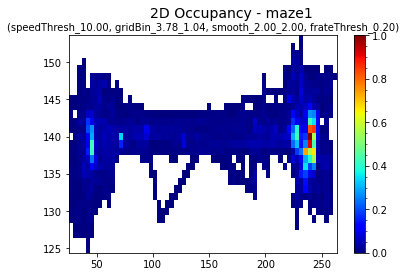

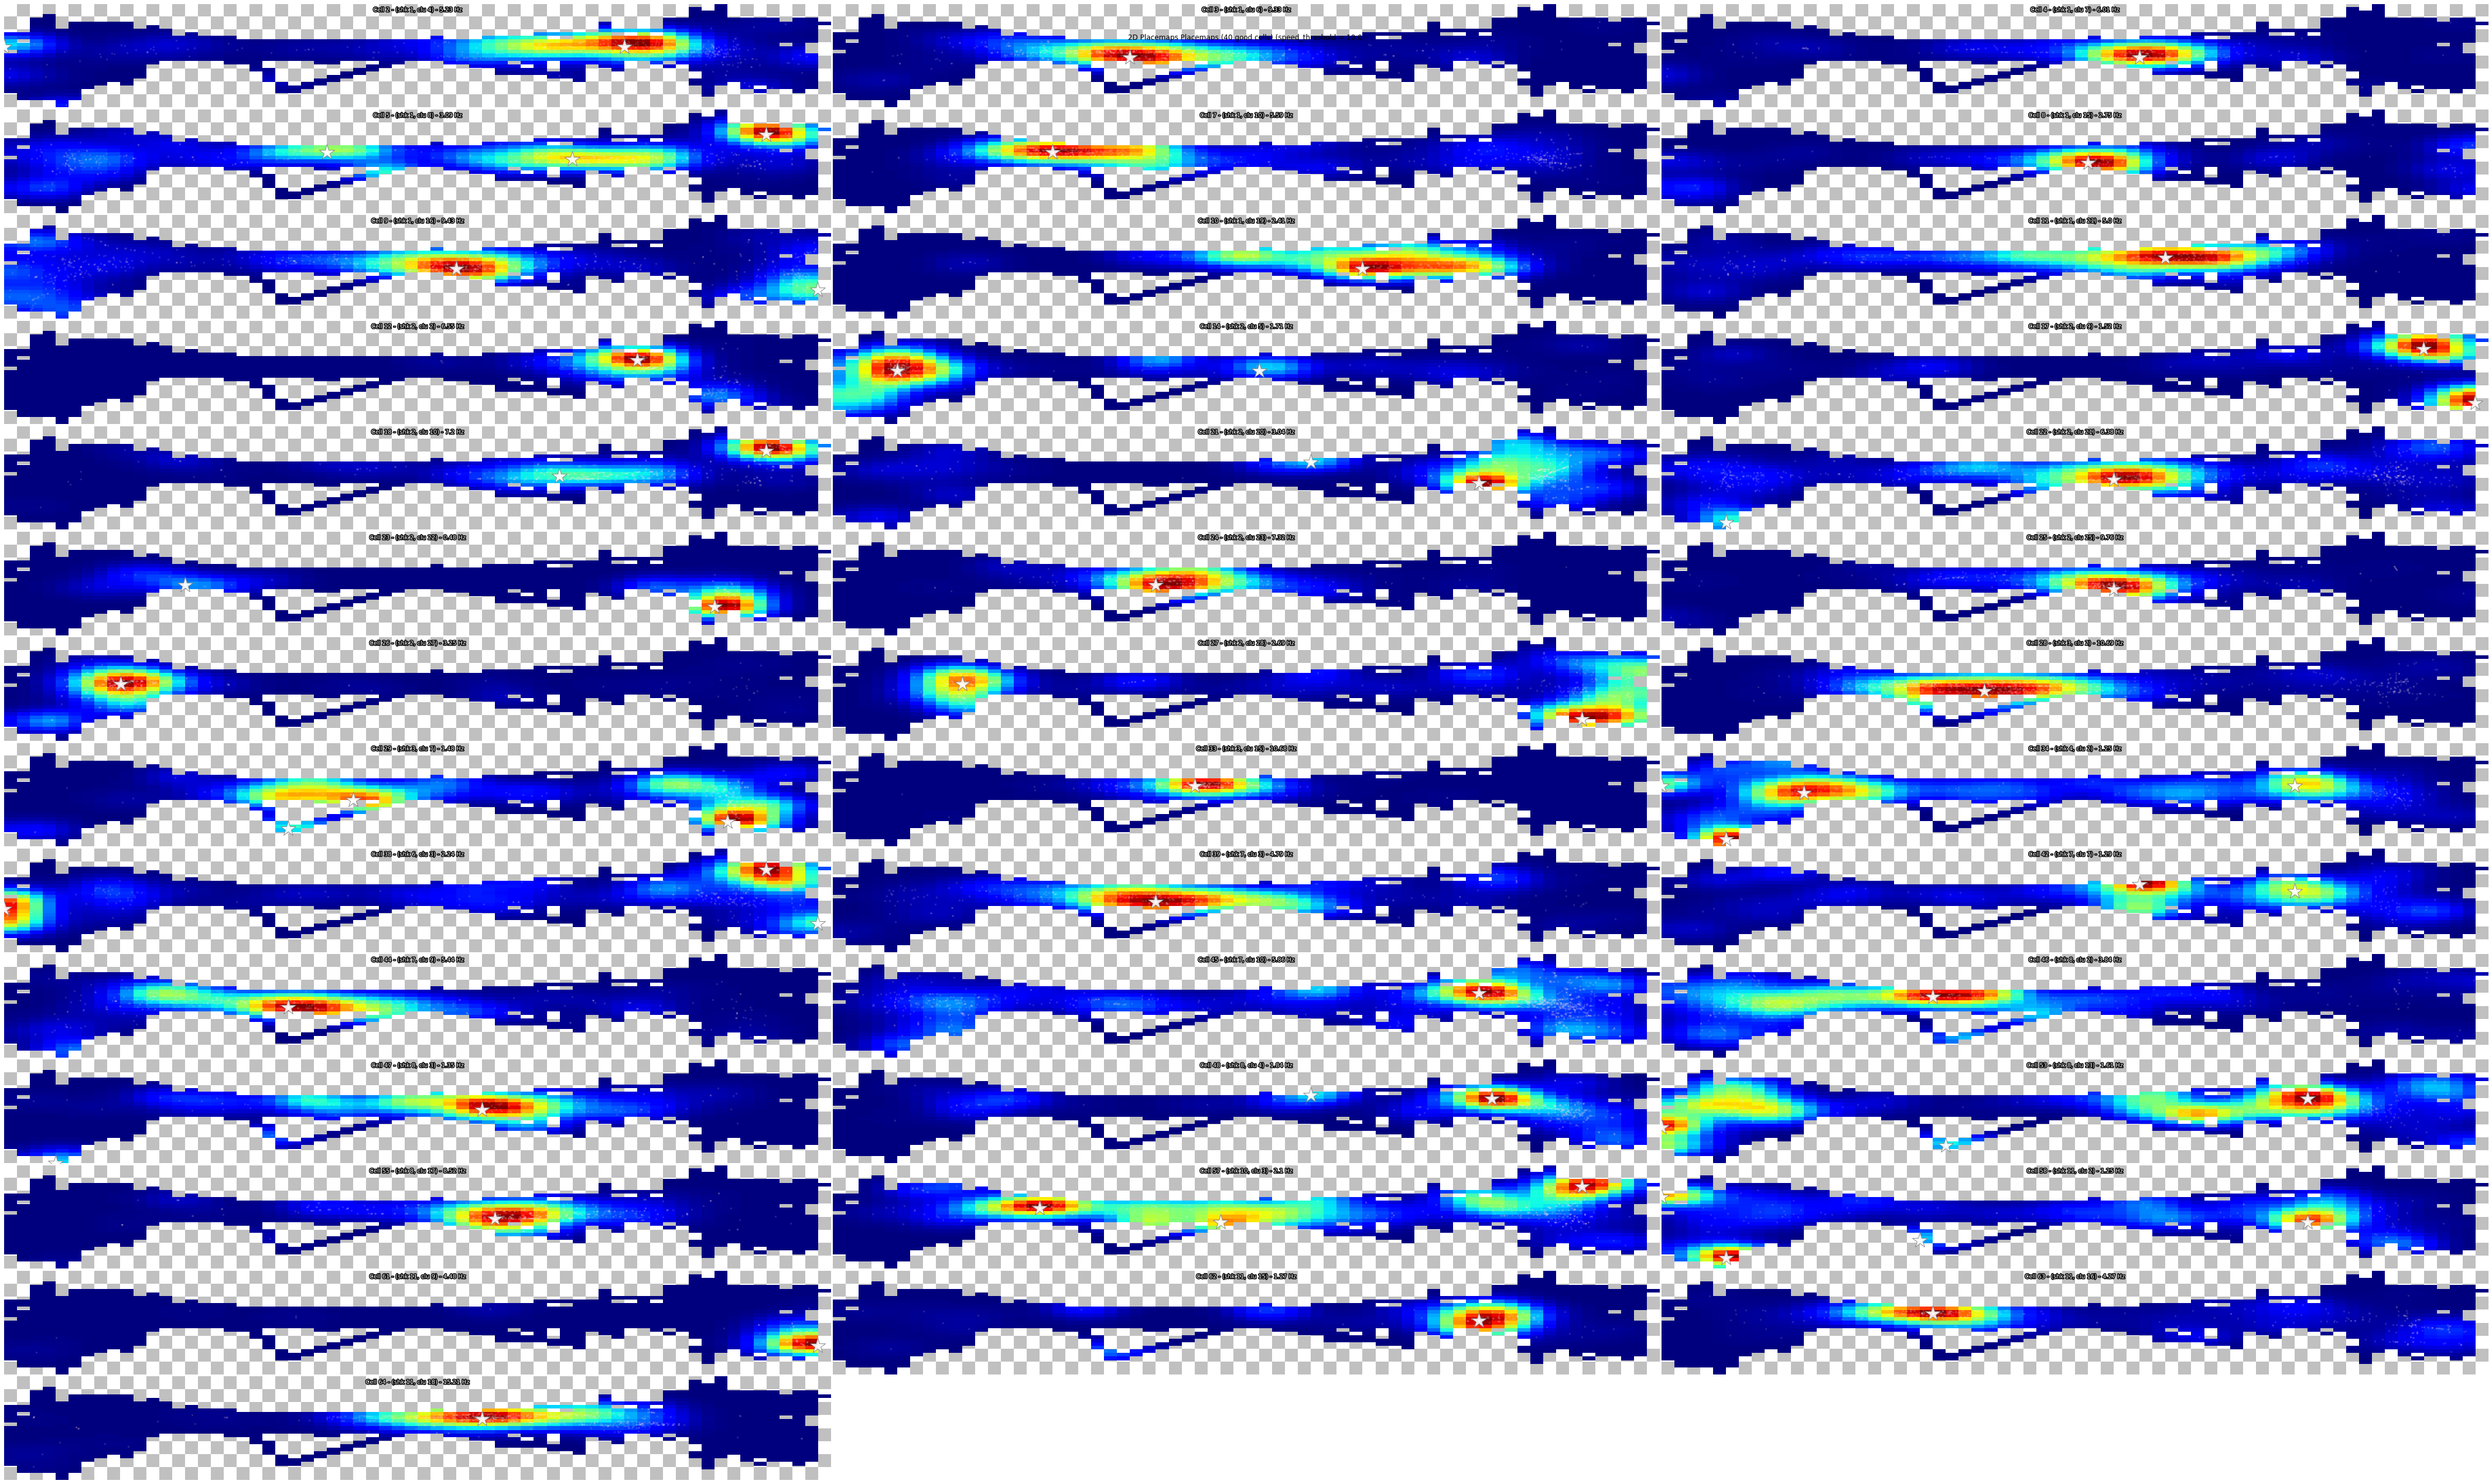

In [49]:

curr_display_function_name = '_display_normal'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    fig0, figList1 = curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk, extended_overlay_points_datasource_dicts=extended_overlay_points_datasource_dicts)
    plots = [fig0, *figList1]
    for a_fig in plots:
        pdf.savefig(a_fig)